# The Detection Game - Comprehensive Data Analysis

This notebook provides comprehensive analysis of the AI art detection study and compare AI and human art detection capabilities.


## Structure
1. **Data Loading and Processing** - Import and clean the data
2. **Human Detectors Analysis** - Quantitative and qualitative analysis of human performance  
3. **AI Detector Analysis** - Analysis of AI detector performance
4. **Human vs AI Comparison** - A comparison between human and AI detection capabilities

## 1. Libraries and Data Loading

In [14]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plot styling
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Use coolwarm color palette
colors = sns.color_palette(palette='coolwarm')

sns.set_palette(colors)


In [15]:
# Load data files
votes_path = "../data/testing_data/votes_data_20251126.csv"
participants_path = "../data/testing_data/participant_data_20251126.csv"
metadata_path = "../data/art_testset_metadata.csv"

# inspect columns of votes and participants data frames
votes = pd.read_csv(votes_path)
print(f"Votes data loaded: {len(votes)} rows, {len(votes.columns)} columns")
print(f"Votes columns: {list(votes.columns)}")
    
participants = pd.read_csv(participants_path)
print(f"\nParticipants data loaded: {len(participants)} rows, {len(participants.columns)} columns")
print(f"Participants columns: {list(participants.columns)}") 


Votes data loaded: 1291 rows, 16 columns
Votes columns: ['id', 'participant_id', 'image_id', 'true_label', 'human_choice', 'confidence', 'response_time_ms', 'timestamp_utc', 'detector_pred', 'detector_confidence', 'reasoning', 'generator_model', 'art_style', 'order_shown', 'correct', 'timestamp']

Participants data loaded: 152 rows, 22 columns
Participants columns: ['participant_id', 'accuracy', 'n_responses', 'started_at', 'finished_at', 'pre_confidence', 'pre_training', 'user_type', 'years_experience', 'art_mediums', 'ai_familiarity', 'ai_frequency', 'difficulty', 'visual_cues', 'hardest_styles', 'labeling_importance', 'encountered_unlabeled', 'concerns', 'detection_value', 'visibility_impact', 'emotions', 'additional_comments']


In [16]:
print("\nVotes data sample:")
print(votes.head())


Votes data sample:
   id participant_id    image_id true_label human_choice  confidence  \
0  70   3d3fdc9c4ae0  img_000500         ai        human         0.5   
1  71   f8958271f363  img_000199      human           ai         0.5   
2  72   f8958271f363  img_000677      human        human         0.5   
3  73   f8958271f363  img_000069         ai           ai         0.5   
4  74   f8958271f363  img_000582      human        human         0.5   

   response_time_ms                     timestamp_utc detector_pred  \
0             27209  2025-11-15T01:58:44.030393+00:00         human   
1             20236  2025-11-15T02:00:03.137076+00:00            ai   
2             11041  2025-11-15T02:00:32.752957+00:00         human   
3             19868  2025-11-15T02:01:02.372618+00:00            ai   
4             14712  2025-11-15T02:01:25.272022+00:00         human   

   detector_confidence reasoning   generator_model       art_style  \
0             0.716807       NaN  stable_diffusion

-----------------------


## 2. Data Cleaning and Processing


### 2.1 Clean votes data (Classification responses)

In [17]:
# Clean votes data (classification responses)
print(f"Original votes: {len(votes)}")

# Remove invalid responses (images that has been 'seen' by participants)
votes_clean = votes[votes['human_choice'] != 'seen'].copy()
print(f"After removing 'seen' responses: {len(votes_clean)}")

# Process timestamp (convert 'timestamp_utc' to datetime objects)
votes['timestamp'] = pd.to_datetime(votes['timestamp_utc'], errors='coerce')

# Select votes from participants who completed the study only
# Based on 'finished_at' column
participants_finished = participants[participants['finished_at'].notna()]
finished_participant_ids = participants_finished['participant_id'].tolist()

# Filter votes to include only those from finished participants
votes_finished = votes_clean[votes_clean['participant_id'].isin(finished_participant_ids)].copy()
print(f"Votes from finished participants: {len(votes_finished)}")



print(f"\nFinal cleaned dataset: {len(votes_finished)} valid votes")


Original votes: 1291
After removing 'seen' responses: 1260
Votes from finished participants: 886

Final cleaned dataset: 886 valid votes


### 2.2 Clean Participants' data (Participants' answers from surveys)

In [18]:
# Clean participants data  
participants_clean = participants_finished.copy()
print(f"Finished participants: {len(participants_clean)}")

print(f"- {len(participants_clean)} completed participants")

Finished participants: 84
- 84 completed participants


### Sample Size Analysis 

In [19]:
# Images Shown in Test Analysis

# Get unique images from votes
unique_images = votes_finished['image_id'].unique()
total_unique_images = len(unique_images)

print(f"Total unique images shown in test: {total_unique_images}")
print(f"Total votes collected: {len(votes_finished)}")
print(f"Average votes per image: {len(votes_finished)/total_unique_images:.1f}")

# Breakdown by true label
image_breakdown = votes_finished.groupby('image_id')['true_label'].first().value_counts()
print(f"\nBreakdown by image type:")
for label, count in image_breakdown.items():
    print(f"  {label.upper()} images: {count}")

# Breakdown by generator
if 'generator_model' in votes_finished.columns:
    generator_breakdown = votes_finished.groupby('image_id')['generator_model'].first().value_counts()
    print(f"\nBreakdown by generator:")
    for gen, count in generator_breakdown.items():
        print(f"  {gen}: {count} images")

# Breakdown by art style  
if 'art_style' in votes_finished.columns:
    style_breakdown = votes_finished.groupby('image_id')['art_style'].first().value_counts()
    print(f"\nTop 10 art styles by number of images:")
    for style, count in style_breakdown.head(10).items():
        print(f"  {style}: {count} images")

# Image usage statistics
votes_per_image = votes_finished.groupby('image_id').size()
print(f"\nImage usage statistics:")
print(f"  Most votes for single image: {votes_per_image.max()}")
print(f"  Least votes for single image: {votes_per_image.min()}")
print(f"  Images with only 1 vote: {len(votes_per_image[votes_per_image == 1])}")
print(f"  Images with 10+ votes: {len(votes_per_image[votes_per_image >= 10])}")

Total unique images shown in test: 571
Total votes collected: 886
Average votes per image: 1.6

Breakdown by image type:
  HUMAN images: 288
  AI images: 283

Breakdown by generator:
  human: 288 images
  stable_diffusion: 53 images
  starryai: 51 images
  original_ldm: 50 images
  dalle: 46 images
  midjourney: 43 images
  dreamstudio: 40 images

Top 10 art styles by number of images:
  illustrations: 85 images
  general_art: 61 images
  surrealism: 31 images
  StarryAI_art: 30 images
  DreamStudio_art: 29 images
  realism: 28 images
  DALL-E_art: 28 images
  renaissance: 27 images
  expressionism: 27 images
  Midjourney_art: 26 images

Image usage statistics:
  Most votes for single image: 9
  Least votes for single image: 1
  Images with only 1 vote: 353
  Images with 10+ votes: 0


Sample sizes by art style:
  illustrations: 128 votes
  general_art: 90 votes
  surrealism: 49 votes
  expressionism: 46 votes
  DALL-E_art: 45 votes
  Midjourney_art: 43 votes
  StarryAI_art: 42 votes
  realism: 42 votes
  DreamStudio_art: 40 votes
  post_impressionism: 38 votes
  renaissance: 38 votes
  impressionism: 37 votes
  StarryAI_pixiv: 35 votes
  baroque: 35 votes
  art_nouveau: 34 votes
  romanticism: 30 votes
  Midjourney_pixiv: 29 votes
  ukiyo_e: 28 votes
  DALL-E_pixiv: 27 votes
  DreamStudio_pixiv: 16 votes
  ukiyo-e: 14 votes


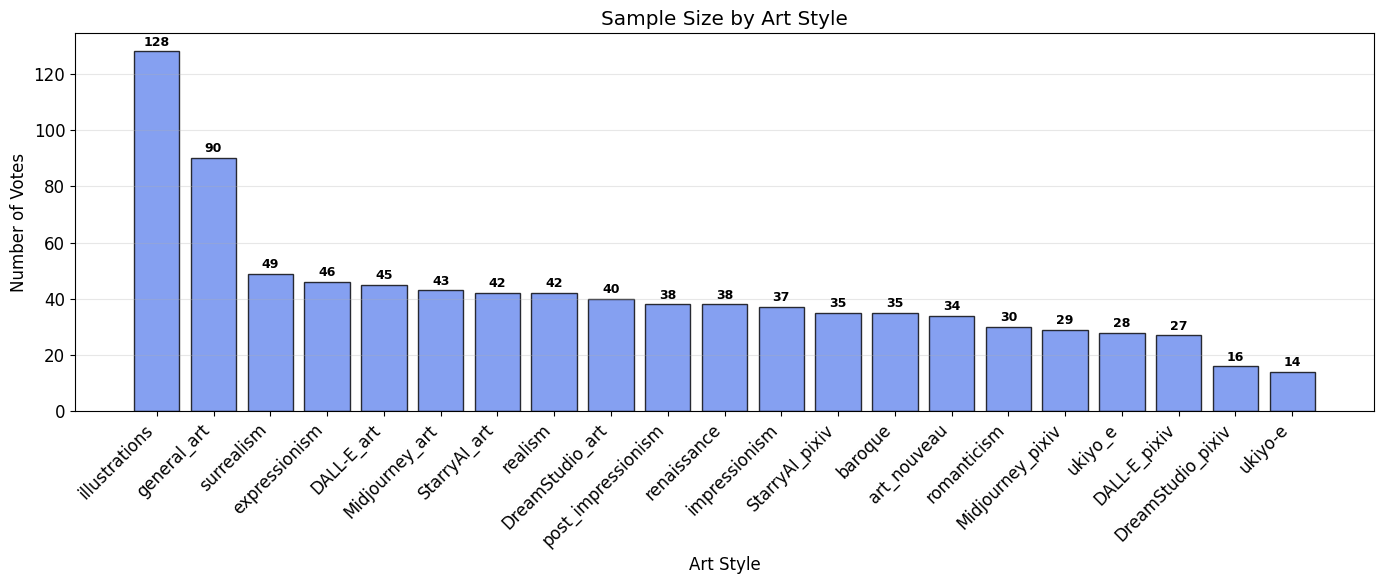

In [20]:
# Sample Size Analysis from Metadata

# Check if art_style is available in votes_finished data
if 'art_style' in votes_finished.columns:
    # Calculate sample sizes by art style
    style_sample_sizes = votes_finished.groupby('art_style').size().sort_values(ascending=False)
    
    print(f"Sample sizes by art style:")
    for style, count in style_sample_sizes.items():
        print(f"  {style}: {count} votes")
    
    # Create sample size chart
    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(style_sample_sizes)), style_sample_sizes.values, 
                  alpha=0.8, edgecolor='black')
    
    plt.xlabel('Art Style')
    plt.ylabel('Number of Votes')
    plt.title('Sample Size by Art Style')
    plt.xticks(range(len(style_sample_sizes)), style_sample_sizes.index, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{style_sample_sizes.iloc[i]}', ha='center', va='bottom', 
                 fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Art style data not available")

## 3. Human Detectors Results

### 3.1 Quantitative Analysis

#### Overview of Participants 

Number of people: 84
Number of votes: 886
Average votes per person: 10.5

User Types:
  Other: 34
  Hobbyist / art student: 32
  Professional designer: 10
  AI researcher or developer: 6
  Professional artist: 2


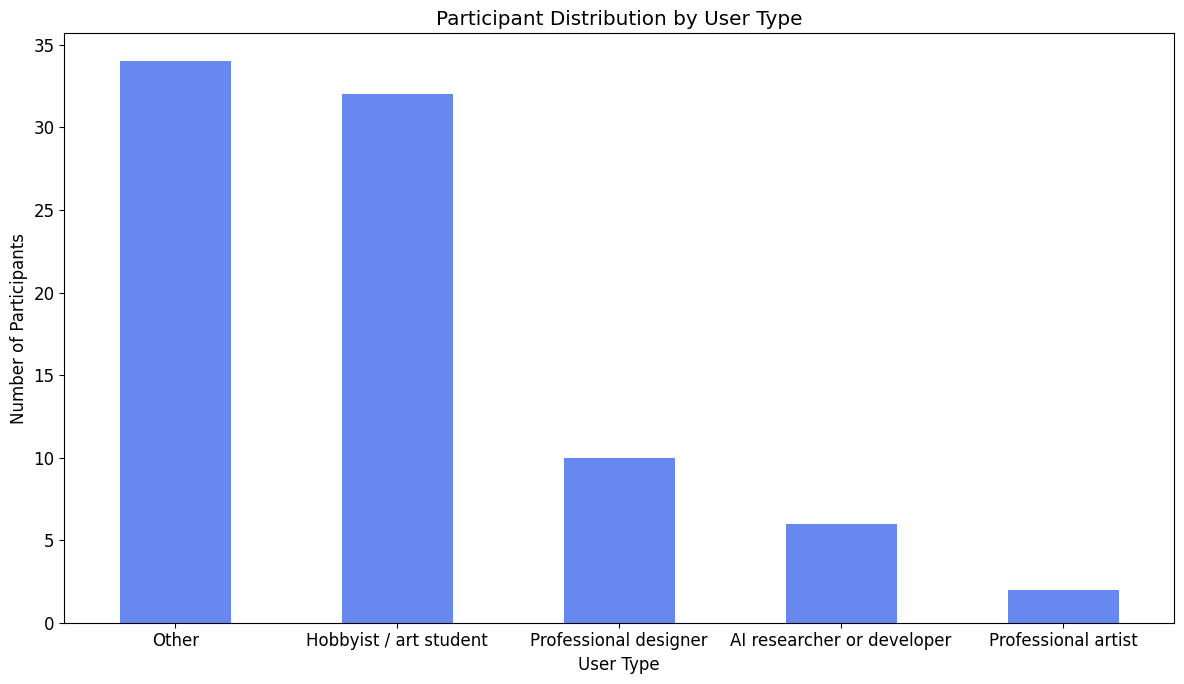

In [21]:
#  Participants' Overview

print(f"Number of people: {len(participants_clean)}")
print(f"Number of votes: {len(votes_finished)}")
print(f"Average votes per person: {len(votes_finished)/len(participants_clean):.1f}")

# User type distribution
user_types = participants_clean['user_type'].value_counts()
print(f"\nUser Types:")
for user_type, count in user_types.items():
    if pd.notna(user_type):
        print(f"  {user_type}: {count}")


# User Type Distribution Visualization
plt.figure(figsize=(12, 7))
user_types.plot(kind='bar')
plt.title('Participant Distribution by User Type')

plt.xlabel('User Type')
plt.ylabel('Number of Participants')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Overall Human Accuracy

In [22]:
print(f"Number of participants: {len(participants_clean)}")
print(f"Median accuracy: {participants_clean['accuracy'].median():.1%}")
print(f"Mean accuracy: {participants_clean['accuracy'].mean():.1%}")
print(f"Standard deviation: {participants_clean['accuracy'].std():.3f}")


Number of participants: 84
Median accuracy: 70.0%
Mean accuracy: 64.7%
Standard deviation: 0.181


In [23]:
#Accuracy by image type:
accuracy_by_type = votes_finished.groupby('true_label')['correct'].mean()
print(f"\nAccuracy by image type:")
print(f"Human accuracy on AI images: {accuracy_by_type.get('ai', 0):.1%}")
print(f"Human accuracy on human images: {accuracy_by_type.get('human', 0):.1%}")


Accuracy by image type:
Human accuracy on AI images: 68.8%
Human accuracy on human images: 63.4%


In [24]:
# Show how many people achieved different accuracy levels

print(" ACCURACY AND NUMBER OF PEOPLE")
accuracy_ranges = [(0, 0.3), (0.3, 0.5), (0.5, 0.7), (0.7, 0.9), (0.9, 1.0)]
for low, high in accuracy_ranges:
    count = len(participants_clean[(participants_clean['accuracy'] >= low) & 
                                  (participants_clean['accuracy'] < high)])
    print(f"  {low:.0%}-{high:.0%}: {count} participants")

# Perfect scores
perfect_scores = len(participants_clean[participants_clean['accuracy'] == 1.0])
print(f"  Perfect scores (100%): {perfect_scores} participants")

 ACCURACY AND NUMBER OF PEOPLE
  0%-30%: 0 participants
  30%-50%: 17 participants
  50%-70%: 23 participants
  70%-90%: 35 participants
  90%-100%: 5 participants
  Perfect scores (100%): 4 participants


NameError: name 'participant_acc_stats' is not defined

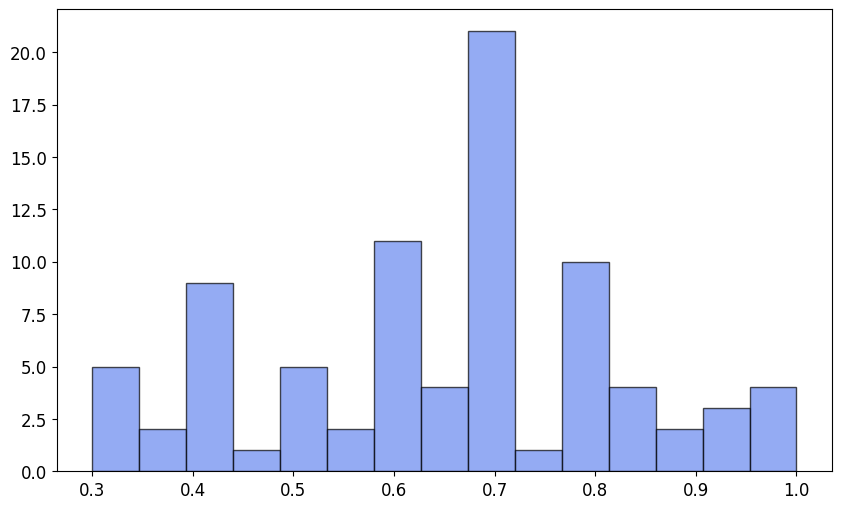

In [25]:
# Participant Accuracy Distribution
plt.figure(figsize=(10, 6))
plt.hist(participants_clean['accuracy'], bins=15, alpha=0.7, edgecolor='black')
plt.axvline(participant_acc_stats['mean'], color='red', linestyle='--', 
           label=f"Mean: {participant_acc_stats['mean']:.1%}")
plt.axvline(participant_acc_stats['50%'], color='blue', linestyle='--', 
           label=f"Median: {participant_acc_stats['50%']:.1%}")
plt.title('Distribution of Participant Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Number of Participants')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

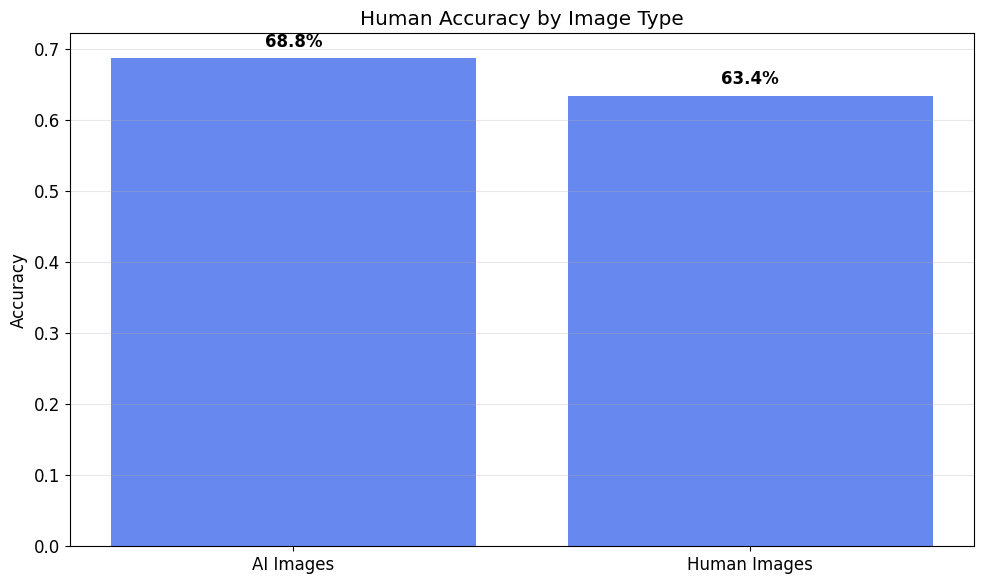

In [ ]:
# Human Accuracy by Image Type
plt.figure(figsize=(10, 6))
image_types = ['AI Images', 'Human Images']
accuracies = [accuracy_by_type.get('ai', 0), accuracy_by_type.get('human', 0)]
bars = plt.bar(image_types, accuracies)
plt.title('Human Accuracy by Image Type')
plt.ylabel('Accuracy')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracies[i]:.1%}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#### Artists vs Non-Artists Performance

                 count   mean    std
artist_category                     
Artist              44  0.693  0.184
Non-Artist          40  0.597  0.166


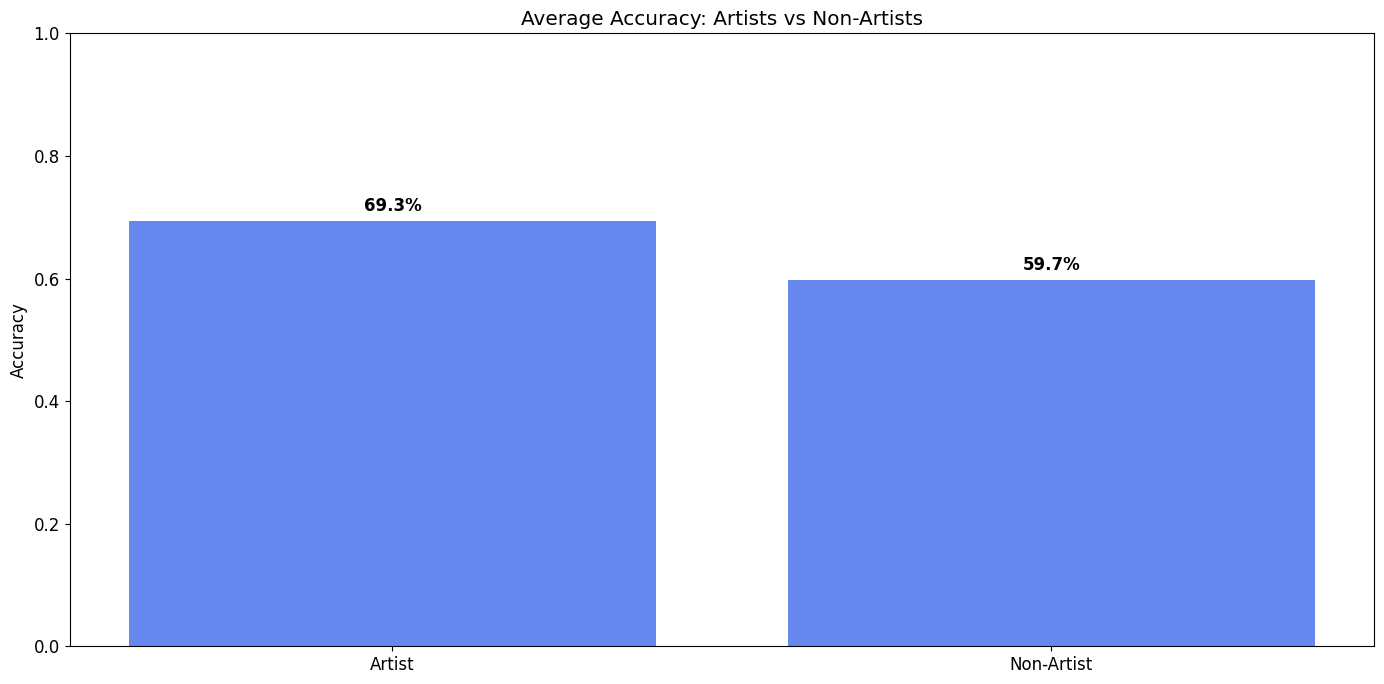

In [ ]:
# Create artist vs non-artist categories
def categorize_user_type(user_type):
    artist_types = ['Professional artist', 'Professional designer', 'Hobbyist / art student']
    if any(artist_type in str(user_type) for artist_type in artist_types):
        return 'Artist'
    else:
        return 'Non-Artist'

participants_clean['artist_category'] = participants_clean['user_type'].apply(categorize_user_type)

# Performance by artist category
artist_performance = participants_clean.groupby('artist_category')['accuracy'].agg(['count', 'mean', 'std']).round(3)
print(artist_performance)



# Average Accuracy: Artists vs Non-Artists
plt.figure(figsize=(14, 7))
artist_acc = participants_clean.groupby('artist_category')['accuracy'].mean()
bars = plt.bar(artist_acc.index, artist_acc)
plt.title('Average Accuracy: Artists vs Non-Artists')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{artist_acc.iloc[i]:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

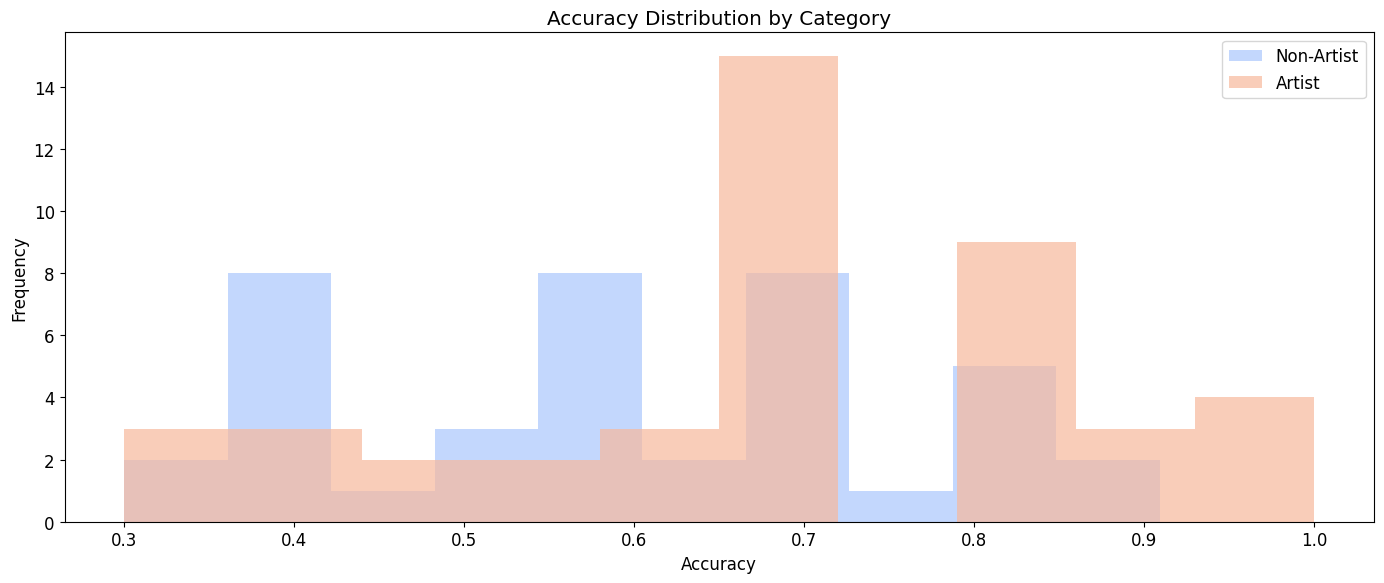

In [ ]:
# Accuracy Distribution by Artist Category
plt.figure(figsize=(14, 6))
colors = sns.color_palette('coolwarm', n_colors=len(participants_clean['artist_category'].unique()))
for i, category in enumerate(participants_clean['artist_category'].unique()):
    if pd.notna(category):
        data = participants_clean[participants_clean['artist_category'] == category]['accuracy']
        plt.hist(data, alpha=0.7, label=category, bins=10, color=colors[i])
plt.title('Accuracy Distribution by Category')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### Yesrs of experience vs accuracy 

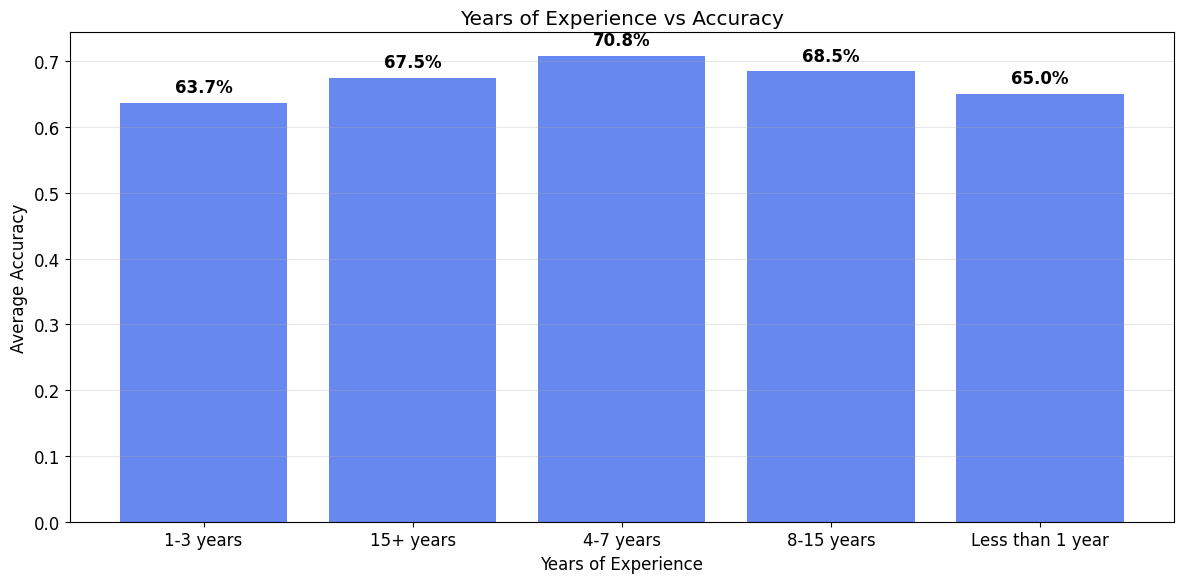

In [ ]:
# Years of Experience vs Accuracy
if 'years_experience' in participants_clean.columns:
    plt.figure(figsize=(12, 6))
    
    # Calculate means by years of experience
    exp_means = participants_clean.groupby('years_experience')['accuracy'].mean().sort_index()
    
    bars = plt.bar(range(len(exp_means)), exp_means.values)
    plt.title('Years of Experience vs Accuracy')
    plt.xlabel('Years of Experience')
    plt.ylabel('Average Accuracy')
    plt.xticks(range(len(exp_means)), exp_means.index, ha='center')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{exp_means.iloc[i]:.1%}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Years of experience data not available")

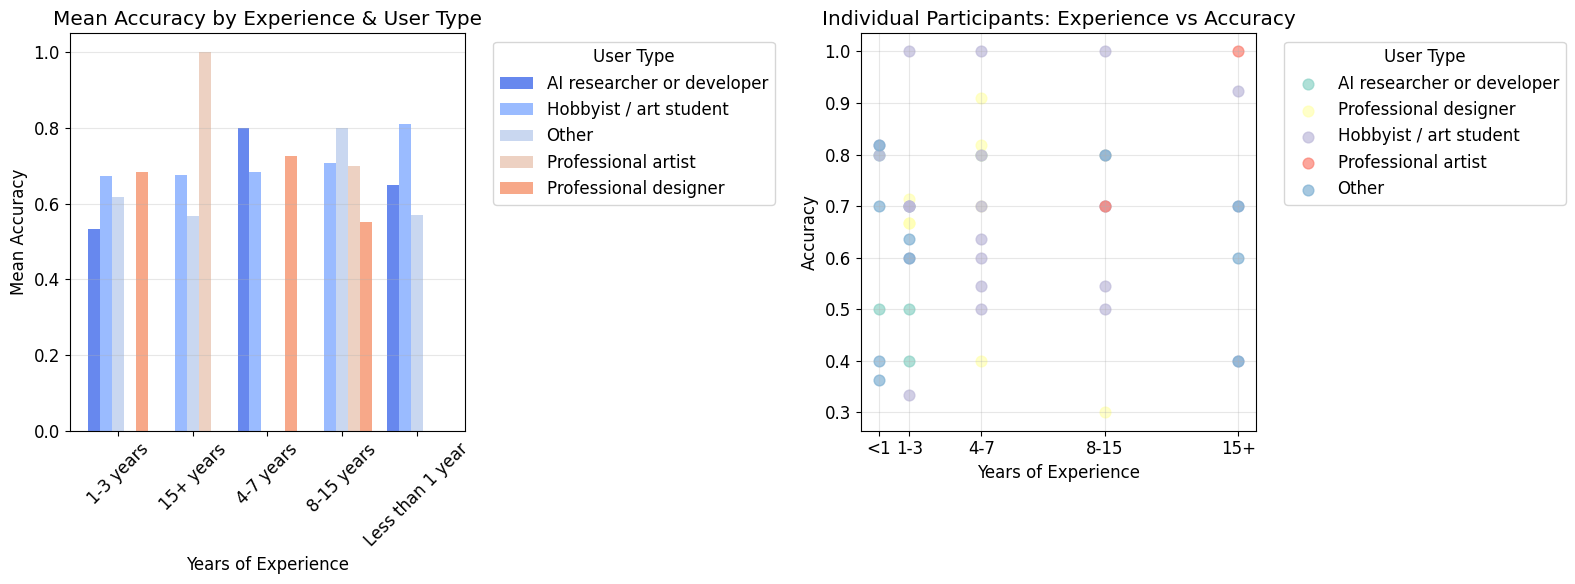


Summary Statistics:
                                             count  median   mean
user_type                  years_experience                      
AI researcher or developer 1-3 years             3   0.500  0.533
                           4-7 years             1   0.800  0.800
                           Less than 1 year      2   0.650  0.650
Hobbyist / art student     1-3 years             6   0.700  0.672
                           15+ years             3   0.700  0.674
                           4-7 years             7   0.636  0.683
                           8-15 years            6   0.700  0.708
                           Less than 1 year      2   0.809  0.809
Other                      1-3 years             2   0.618  0.618
                           15+ years             3   0.600  0.567
                           8-15 years            1   0.800  0.800
                           Less than 1 year      4   0.550  0.570
Professional artist        15+ years             1   1.

In [ ]:
# Years of Experience, User Type, and Accuracy Combined
# This cell is generated by Claude AI assistant 

if 'years_experience' in participants_clean.columns and 'user_type' in participants_clean.columns:
    # First, let's clean and convert experience to numeric for plotting
    participants_plot = participants_clean.copy()
    
    # Map experience categories to numeric values
    exp_mapping = {
        'Less than 1 year': 0.5,
        '1-3 years': 2,
        '4-7 years': 5.5,
        '8-15 years': 11.5,
        '15+ years': 18
    }
    
    participants_plot['exp_numeric'] = participants_plot['years_experience'].map(exp_mapping)
    
    # Remove rows with NaN experience or user_type
    participants_plot = participants_plot.dropna(subset=['exp_numeric', 'user_type', 'accuracy'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Grouped bar chart by experience and user type
    exp_type_means = participants_plot.groupby(['years_experience', 'user_type'])['accuracy'].mean().unstack(fill_value=0)
    
    exp_type_means.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Mean Accuracy by Experience & User Type')
    ax1.set_xlabel('Years of Experience')
    ax1.set_ylabel('Mean Accuracy')
    ax1.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Scatter plot with color coding (using numeric experience)
    user_types = participants_plot['user_type'].unique()
    colors = plt.cm.Set3(range(len(user_types)))
    
    for i, user_type in enumerate(user_types):
        subset = participants_plot[participants_plot['user_type'] == user_type]
        ax2.scatter(subset['exp_numeric'], subset['accuracy'], 
                   c=[colors[i]], label=user_type, alpha=0.7, s=60)
    
    ax2.set_title('Individual Participants: Experience vs Accuracy')
    ax2.set_xlabel('Years of Experience')
    ax2.set_ylabel('Accuracy')
    ax2.set_xticks([0.5, 2, 5.5, 11.5, 18])
    ax2.set_xticklabels(['<1', '1-3', '4-7', '8-15', '15+'])
    ax2.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\nSummary Statistics:")
    summary = participants_plot.groupby(['user_type', 'years_experience'])['accuracy'].agg(['count', 'median', 'mean']).round(3)
    print(summary)
else:
    print("Required columns not available")


### Confidence vs Accuracy Analysis

In [ ]:

# Participant-level: pre-confidence vs accuracy
pre_conf_acc = participants_clean.groupby('pre_confidence')['accuracy'].agg(['count', 'mean', 'std']).round(3)
print("\nPre-confidence vs final accuracy:")
print(pre_conf_acc)



Pre-confidence vs final accuracy:
                                                 count   mean    std
pre_confidence                                                      
Not confident at all - I can rarely tell             3  0.455  0.127
Not very confident                                  23  0.605  0.155
Somewhat confident                                  39  0.625  0.190
Very confident - I can usually tell immediately     19  0.774  0.134


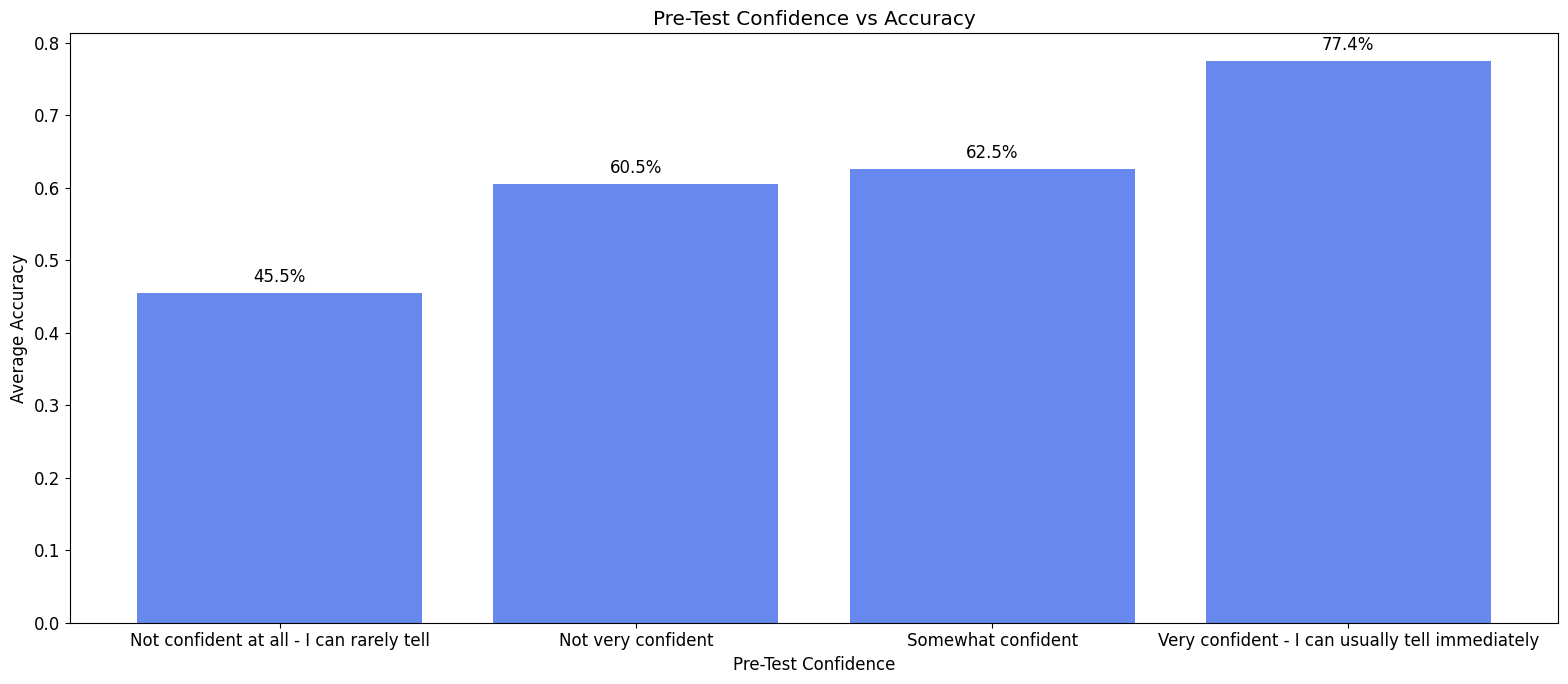

In [ ]:
# Pre-Test Confidence vs  Accuracy Chart
if 'confidence' in votes_finished.columns:
    plt.figure(figsize=(16, 7))
    pre_conf_means = participants_clean.groupby('pre_confidence')['accuracy'].mean()
    bars = plt.bar(range(len(pre_conf_means)), pre_conf_means.values)
    plt.title('Pre-Test Confidence vs Accuracy')
    plt.xlabel('Pre-Test Confidence')
    plt.ylabel('Average Accuracy')
    plt.xticks(range(len(pre_conf_means)), pre_conf_means.index, rotation=0, ha='center')
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{pre_conf_means.iloc[i]:.1%}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

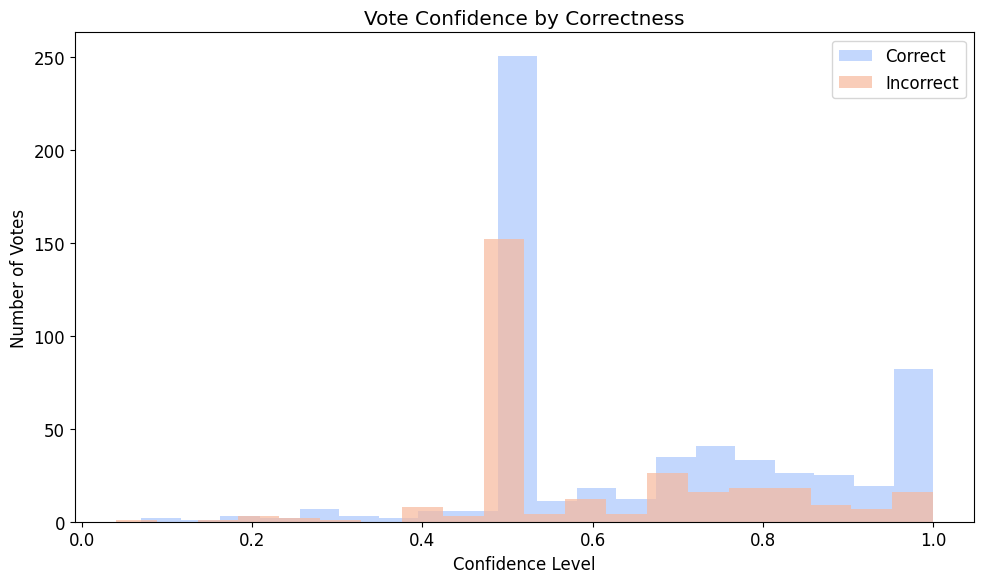

In [ ]:
# Vote (Answers) Confidence by Correctness
if 'confidence' in votes_finished.columns:
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette('coolwarm', n_colors=2)
    for i, correct in enumerate([True, False]):
        subset = votes_finished[votes_finished['correct'] == correct]['confidence']
        label = 'Correct' if correct else 'Incorrect'
        plt.hist(subset, alpha=0.7, label=label, bins=20, color=colors[i])
    plt.title('Vote Confidence by Correctness')
    plt.xlabel('Confidence Level')
    plt.ylabel('Number of Votes')
    plt.legend()
    plt.tight_layout()
    plt.show()

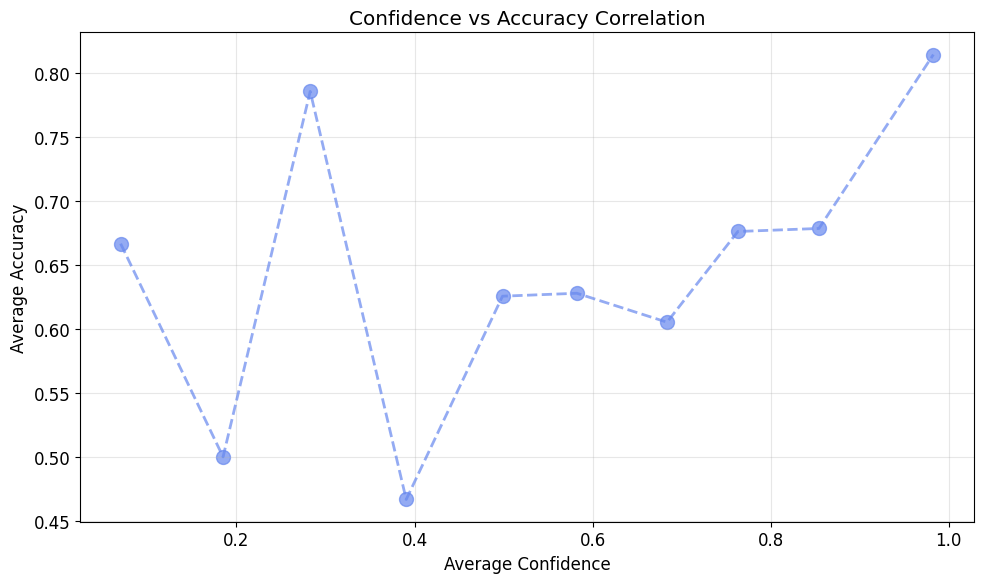

In [ ]:
# Vote (Answers) Confidence vs Accuracy Correlation

if 'confidence' in votes_finished.columns:
    plt.figure(figsize=(10, 6))
    confidence_bins = pd.cut(votes_finished['confidence'], bins=10)
    conf_acc_analysis = votes_finished.groupby(confidence_bins).agg({
        'correct': 'mean',
        'confidence': 'mean'
    }).dropna()
    
    plt.scatter(conf_acc_analysis['confidence'], conf_acc_analysis['correct'], 
               s=100, alpha=0.7)
    plt.plot(conf_acc_analysis['confidence'], conf_acc_analysis['correct'], 
             linestyle='--', alpha=0.7, linewidth=2)
    plt.title('Confidence vs Accuracy Correlation')
    plt.xlabel('Average Confidence')
    plt.ylabel('Average Accuracy')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#### Detection Training vs Accuracy

In [ ]:
# Training and AI familiarity analysis
# Training categories
training_acc = participants_clean.groupby('pre_training')['accuracy'].agg(['count', 'mean', 'std']).round(3)
print("Training vs Accuracy:")
print(training_acc)



Training vs Accuracy:
                                                count   mean    std
pre_training                                                       
No                                                 59  0.644  0.180
Yes, formal training                                3  0.708  0.212
Yes, informal (videos, articles, social media)     22  0.647  0.190


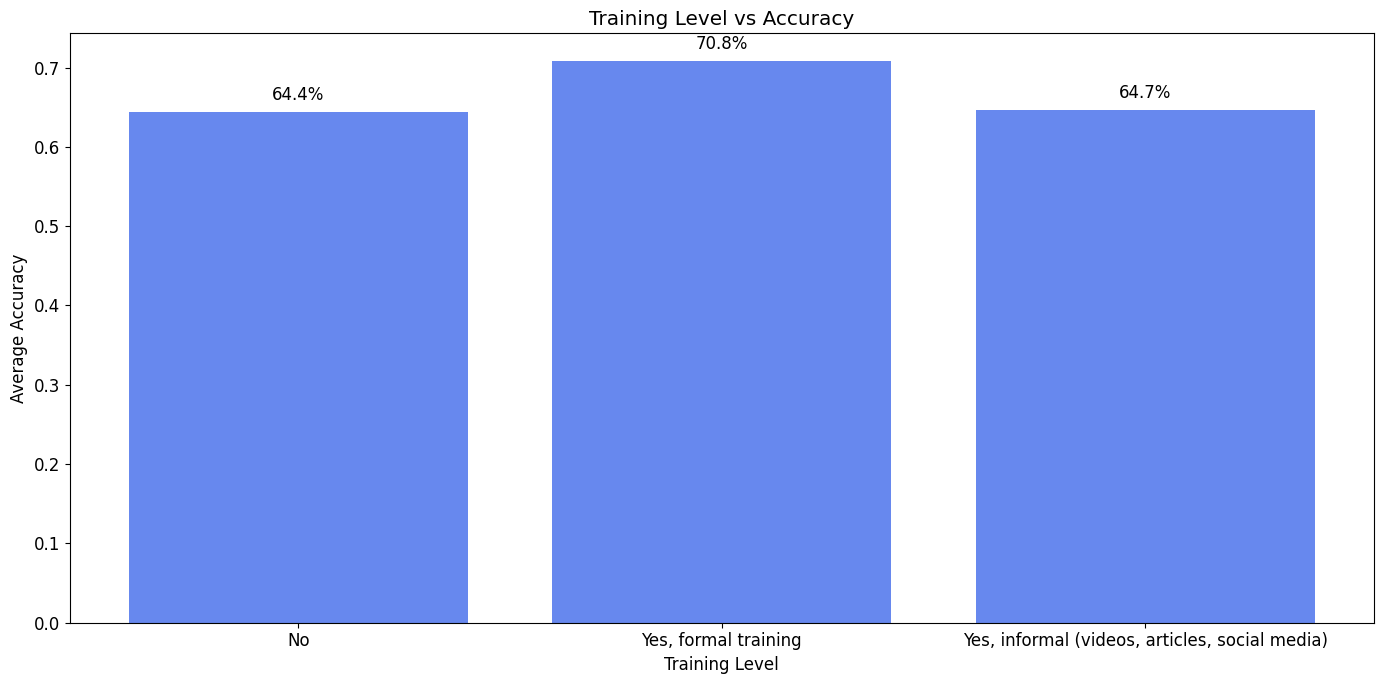

In [ ]:
# Training Level vs Accuracy
plt.figure(figsize=(14, 7))
training_means = participants_clean.groupby('pre_training')['accuracy'].mean()
bars = plt.bar(range(len(training_means)), training_means.values)
plt.title('Training Level vs Accuracy')
plt.xlabel('Training Level')
plt.ylabel('Average Accuracy')
plt.xticks(range(len(training_means)), training_means.index, rotation=0, ha='center')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{training_means.iloc[i]:.1%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
# Familiarity with AI Art tools vs Accuracy

if 'ai_familiarity' in participants_clean.columns:
    ai_fam_acc = participants_clean.groupby('ai_familiarity')['accuracy'].agg(['count', 'mean', 'std']).round(3)
    print("AI Art Tools Familiarity vs Accuracy:")
    print(ai_fam_acc)



AI Art Tools Familiarity vs Accuracy:
                         count   mean    std
ai_familiarity                              
Never used AI art tools     45  0.650  0.189
Regular user                 8  0.570  0.189
Used them a few times       31  0.663  0.170


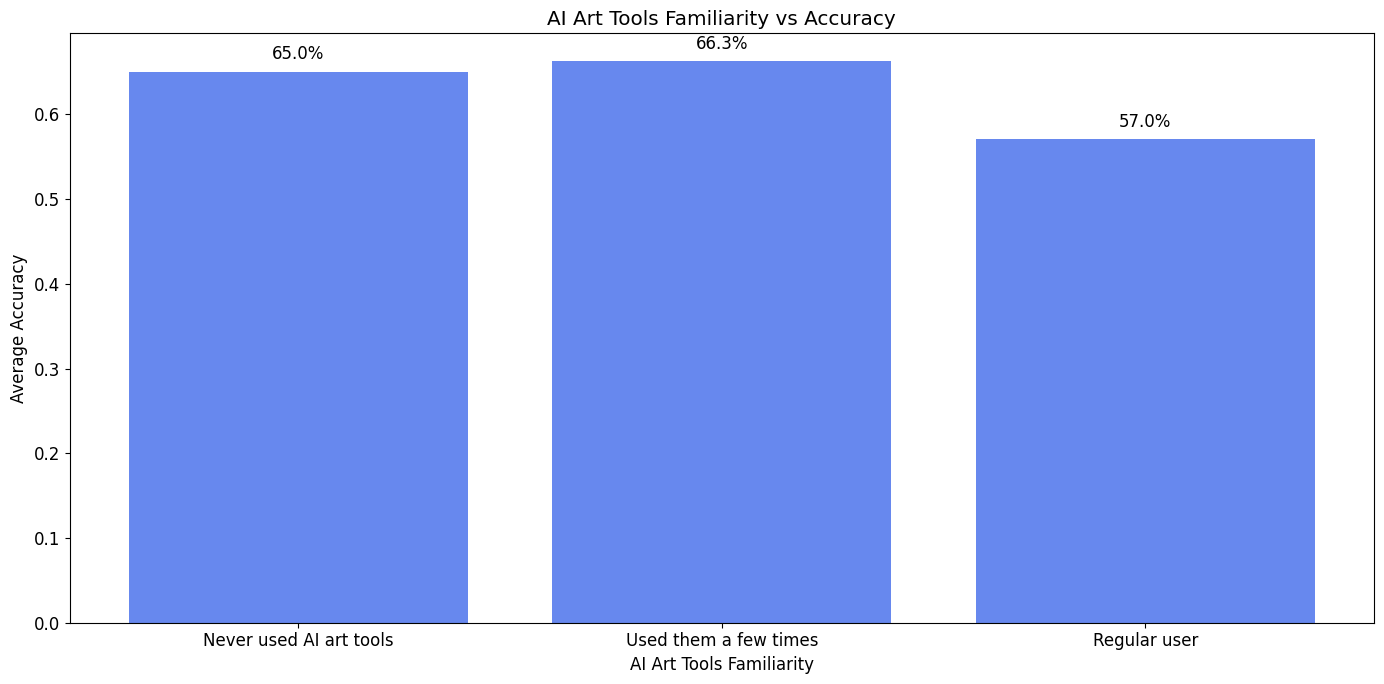

In [ ]:
# AI Familiarity vs Accuracy
if 'ai_familiarity' in participants_clean.columns:
    plt.figure(figsize=(14, 7))
    
    # Define the order for familiarity levels
    familiarity_order = ['Never used AI art tools', 'Used them a few times', 'Regular user']
    
    # Calculate means in the specified order
    fam_means = participants_clean.groupby('ai_familiarity')['accuracy'].mean()
    fam_means = fam_means.reindex(familiarity_order)
    
    bars = plt.bar(range(len(fam_means)), fam_means.values)
    plt.title('AI Art Tools Familiarity vs Accuracy')
    plt.xlabel('AI Art Tools Familiarity')
    plt.ylabel('Average Accuracy')
    plt.xticks(range(len(fam_means)), fam_means.index, ha='center')
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{fam_means.iloc[i]:.1%}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
else:
    print("AI Familiarity data not available")

In [ ]:
# Frequency of seeing AI art online vs Accuracy
if 'ai_frequency' in participants_clean.columns:
    ai_freq_acc = participants_clean.groupby('ai_frequency')['accuracy'].agg(['count', 'mean', 'std']).round(3)
    print("Frequency of seeing AI art online vs Accuracy:")
    print(ai_freq_acc)

Frequency of seeing AI art online vs Accuracy:
                 count   mean    std
ai_frequency                        
Never               15  0.675  0.194
Often               25  0.647  0.189
Rarely               6  0.541  0.147
Sometimes           23  0.646  0.160
Very frequently     15  0.664  0.205


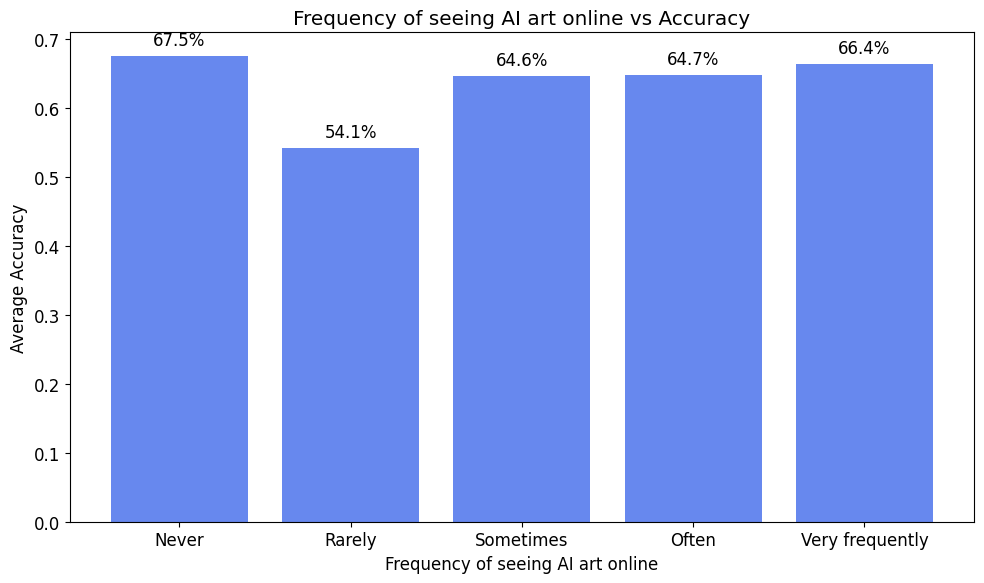

In [ ]:
# Frequency of seeing AI art online vs Accuracy
if 'ai_frequency' in participants_clean.columns:
    plt.figure(figsize=(10, 6))

    # Define the order for Frequency levels
    frequency_order = ['Never', 'Rarely', 'Sometimes', 'Often', 'Very frequently']
    
    # Calculate means in the specified order
    freq_means = participants_clean.groupby('ai_frequency')['accuracy'].mean()
    freq_means= freq_means.reindex(frequency_order)
    
 
    bars = plt.bar(range(len(freq_means)), freq_means.values)
    plt.title('Frequency of seeing AI art online vs Accuracy')
    plt.xlabel('Frequency of seeing AI art online')
    plt.ylabel('Average Accuracy')
    plt.xticks(range(len(freq_means)), freq_means.index, ha='center')
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{freq_means.iloc[i]:.1%}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
else:
    print("AI Frequency data not available")

<Figure size 1600x600 with 0 Axes>

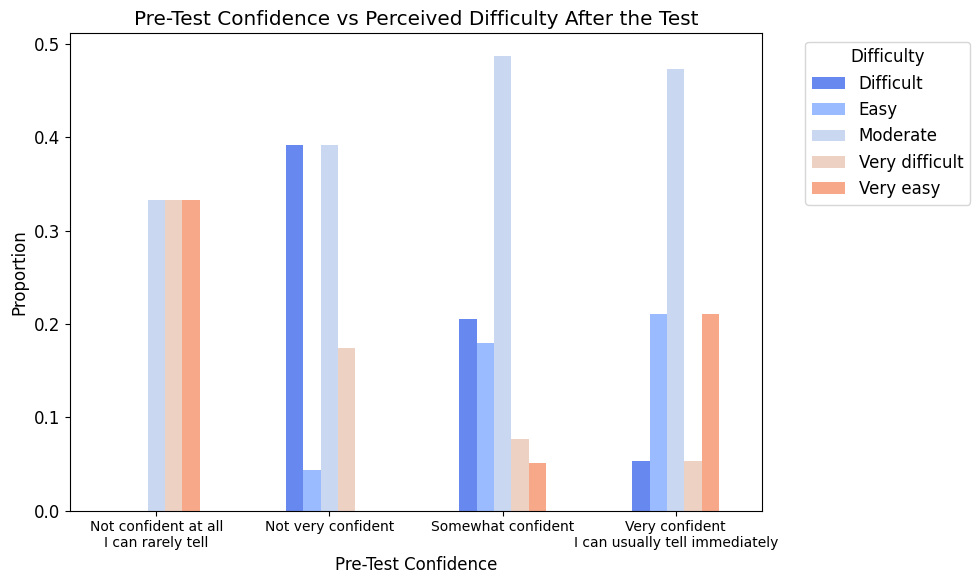

In [ ]:
# Pre-Confidence vs Perceived Difficulty after the test

if 'difficulty' in participants_clean.columns:
    plt.figure(figsize=(16, 6))
    conf_diff = pd.crosstab(participants_clean['pre_confidence'], 
                           participants_clean['difficulty'], normalize='index')
    
    conf_diff.plot(kind='bar', stacked=False)
    plt.title('Pre-Test Confidence vs Perceived Difficulty After the Test')
    plt.xlabel('Pre-Test Confidence')
    plt.ylabel('Proportion')
    plt.legend(title='Difficulty', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create two-line labels
    labels = [label.replace(' - ', '\n') for label in conf_diff.index]
    plt.xticks(range(len(labels)), labels, rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("Difficulty data not available")

### Hardest Models and Styles to Detect

#### 1. Hardest AI Models To Detect

In [ ]:

# Accuracy by generator model
if 'generator_model' in votes_finished.columns:
    gen_accuracy = votes_finished.groupby('generator_model').agg({
        'correct': ['count', 'mean'],
        'confidence': 'mean' if 'confidence' in votes_finished.columns else 'count'
    }).round(3)
    gen_accuracy.columns = ['Total_Votes', 'Accuracy', 'Avg_Confidence']
    gen_accuracy = gen_accuracy.reset_index().sort_values('Accuracy')
    
    print("Generator Detection Accuracy (sorted by difficulty):")
    for _, row in gen_accuracy.iterrows():
        conf_str = f", confidence: {row['Avg_Confidence']:.1%}" if 'confidence' in votes_finished.columns else ""
        print(f"  {row['generator_model']}: {row['Accuracy']:.1%} ({row['Total_Votes']} votes{conf_str})")


# Show top hardest and easiest
    if 'generator_model' in votes_finished.columns:
        print(f"\n Hardest generator to detect: {gen_accuracy.iloc[0]['generator_model']} ({gen_accuracy.iloc[0]['Accuracy']:.1%})")
        print(f" Easiest generator to detect: {gen_accuracy.iloc[-1]['generator_model']} ({gen_accuracy.iloc[-1]['Accuracy']:.1%})")
    
    

Generator Detection Accuracy (sorted by difficulty):
  dalle: 56.9% (72 votes, confidence: 62.5%)
  stable_diffusion: 61.9% (84 votes, confidence: 65.3%)
  human: 63.4% (454 votes, confidence: 62.2%)
  dreamstudio: 64.3% (56 votes, confidence: 67.2%)
  midjourney: 68.1% (72 votes, confidence: 66.8%)
  starryai: 79.2% (77 votes, confidence: 70.5%)
  original_ldm: 81.7% (71 votes, confidence: 65.5%)

 Hardest generator to detect: dalle (56.9%)
 Easiest generator to detect: original_ldm (81.7%)


#### 2. Hardest Styles To Detect

In [ ]:
# Accuracy by art style
if 'art_style' in votes_finished.columns:
    style_accuracy = votes_finished.groupby('art_style').agg({
        'correct': ['count', 'mean'],
        'confidence': 'mean' if 'confidence' in votes_finished.columns else 'count'
    }).round(3)
    style_accuracy.columns = ['Total_Votes', 'Accuracy', 'Avg_Confidence']
    style_accuracy = style_accuracy.reset_index().sort_values('Accuracy')
    
    print("Style Detection Accuracy (sorted by difficulty):")
    for _, row in style_accuracy.head(10).iterrows():
        conf_str = f", confidence: {row['Avg_Confidence']:.1%}" if 'confidence' in votes_finished.columns else ""
        print(f"  {row['art_style']}: {row['Accuracy']:.1%} ({row['Total_Votes']} votes{conf_str})")
        
    print(f"\n Hardest style to detect: {style_accuracy.iloc[0]['art_style']} ({style_accuracy.iloc[0]['Accuracy']:.1%})")
    print(f" Easiest style to detect: {style_accuracy.iloc[-1]['art_style']} ({style_accuracy.iloc[-1]['Accuracy']:.1%})")

else:
    print("Generator/style data not available")

Style Detection Accuracy (sorted by difficulty):
  DALL-E_art: 51.1% (45 votes, confidence: 57.5%)
  expressionism: 54.3% (46 votes, confidence: 59.2%)
  DreamStudio_art: 57.5% (40 votes, confidence: 66.6%)
  general_art: 58.9% (90 votes, confidence: 60.5%)
  illustrations: 60.2% (128 votes, confidence: 62.5%)
  Midjourney_art: 60.5% (43 votes, confidence: 62.6%)
  surrealism: 61.2% (49 votes, confidence: 66.5%)
  DALL-E_pixiv: 66.7% (27 votes, confidence: 70.8%)
  art_nouveau: 67.6% (34 votes, confidence: 66.0%)
  impressionism: 67.6% (37 votes, confidence: 63.7%)

 Hardest style to detect: DALL-E_art (51.1%)
 Easiest style to detect: DreamStudio_pixiv (81.2%)


In [ ]:
# Show what participants thought were hardest
print("\n=== PARTICIPANT REPORTED HARDEST STYLES ===")
if 'hardest_styles' in participants_clean.columns:
    hardest_reported = participants_clean['hardest_styles'].value_counts()
    print("Styles participants reported as hardest:")
    for style, count in hardest_reported.head(10).items():
        if pd.notna(style):
            print(f"  {style}: {count} mentions")
else:
    print("Participant hardest style data not available")


=== PARTICIPANT REPORTED HARDEST STYLES ===
Styles participants reported as hardest:
  Abstract art: 22 mentions
  Paintings: 16 mentions
  Anime/illustrations: 12 mentions
  Abstract art,Paintings: 5 mentions
  Anime/illustrations,Paintings: 5 mentions
  Sketches: 4 mentions
  Paintings,Sketches: 3 mentions
  Sketches,Abstract art: 2 mentions
  Abstract art,Sketches: 2 mentions
  Anime/illustrations,Abstract art: 1 mentions


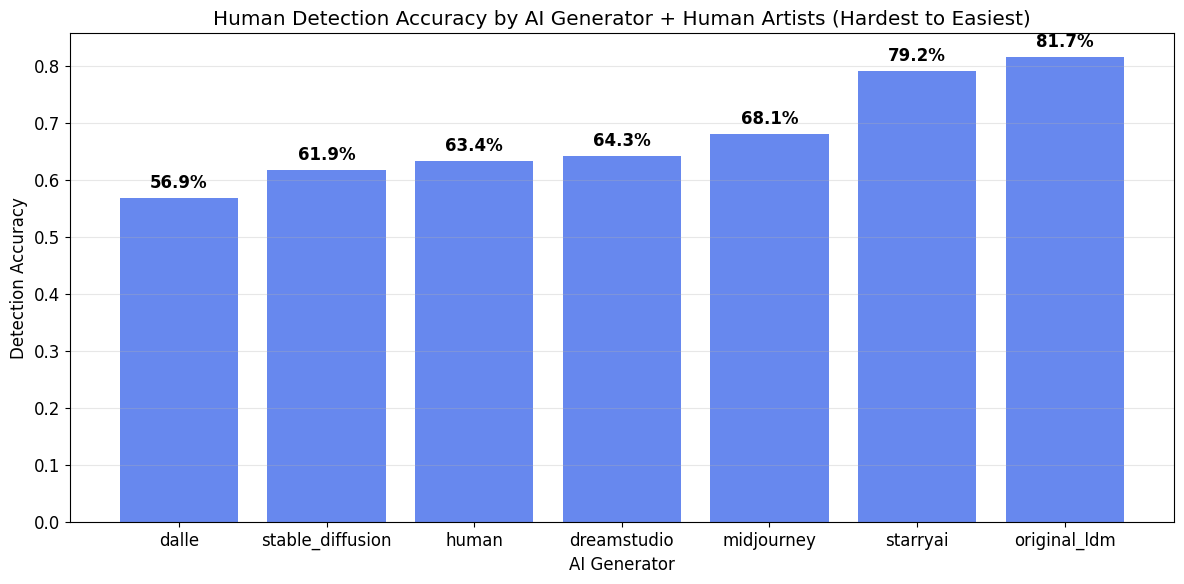

In [ ]:
# Human Detection Accuracy by Generator + human artists
if 'generator_model' in votes_finished.columns:
    # Calculate accuracy by generator
    gen_accuracy = votes_finished.groupby('generator_model').agg({
        'correct': ['count', 'mean'],
        'confidence': 'mean' if 'confidence' in votes_finished.columns else 'count'
    }).round(3)
    gen_accuracy.columns = ['Total_Votes', 'Accuracy', 'Avg_Confidence']
    gen_accuracy = gen_accuracy.reset_index().sort_values('Accuracy')
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(gen_accuracy)), gen_accuracy['Accuracy'])
    plt.title('Human Detection Accuracy by AI Generator + Human Artists (Hardest to Easiest)')
    plt.xlabel('AI Generator')
    plt.ylabel('Detection Accuracy')
    plt.xticks(range(len(gen_accuracy)), gen_accuracy['generator_model'], ha='center')
    
    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{gen_accuracy.iloc[i]["Accuracy"]:.1%}', 
                 ha='center', va='bottom', fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Generator data not available")

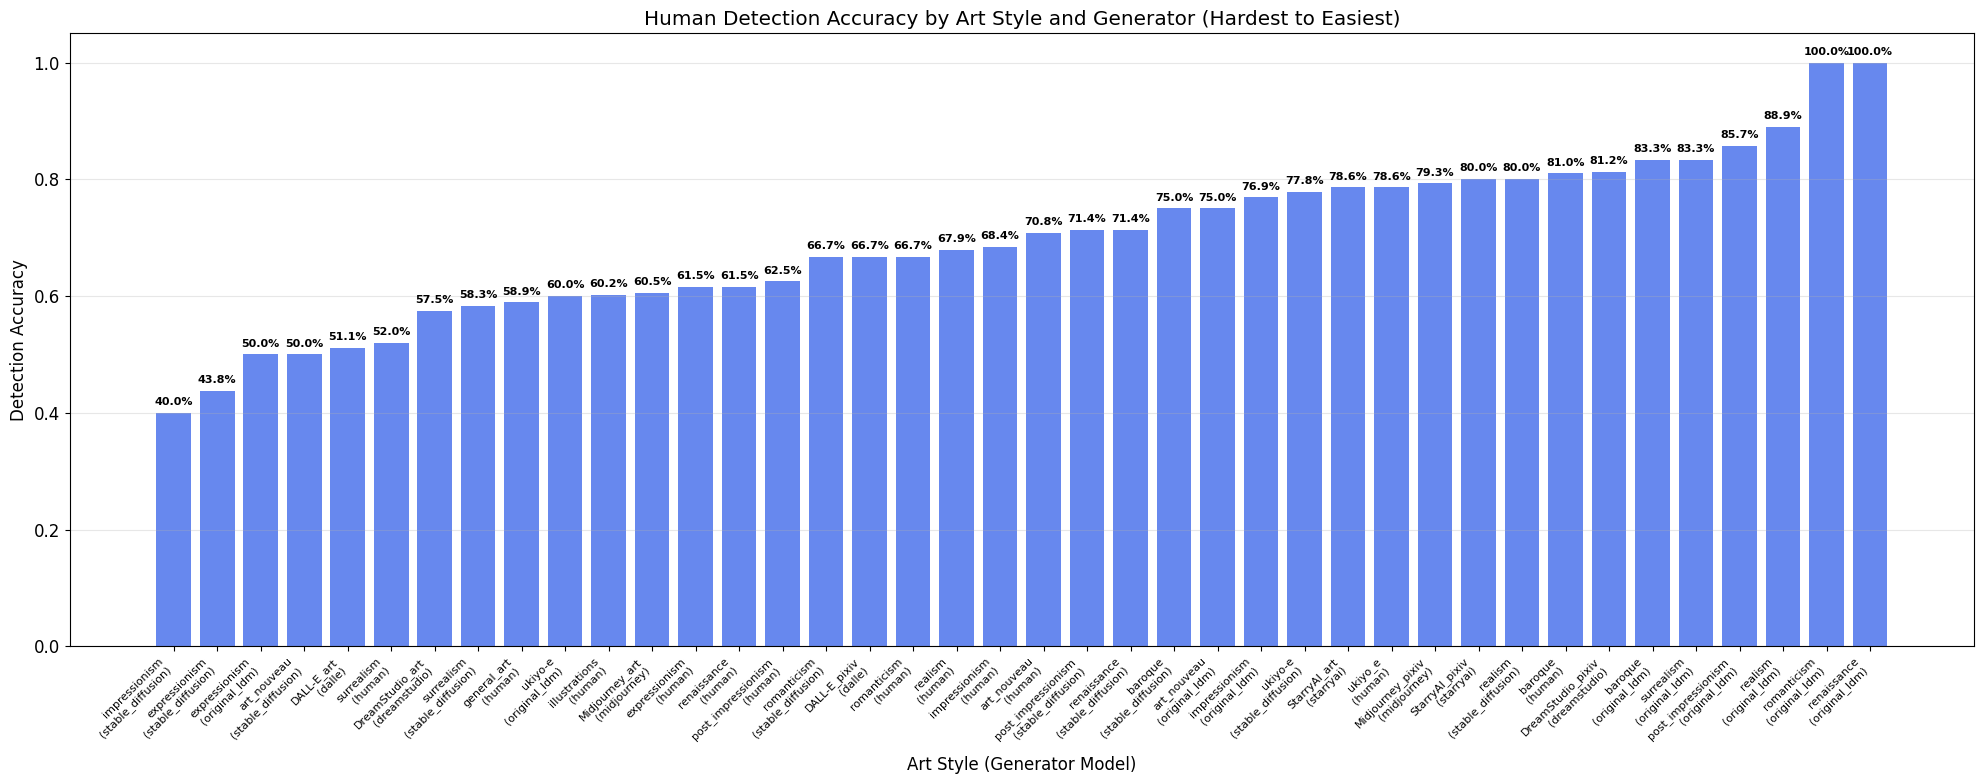

In [ ]:
# Human Detection Accuracy by Art Style
# This cell is generated by Claude AI assistant 
if 'art_style' in votes_finished.columns:
    # Calculate accuracy by art style and generator model
    style_gen_accuracy = votes_finished.groupby(['art_style', 'generator_model']).agg({
        'correct': ['count', 'mean'],
        'confidence': 'mean' if 'confidence' in votes_finished.columns else 'count'
    }).round(3)
    style_gen_accuracy.columns = ['Total_Votes', 'Accuracy', 'Avg_Confidence']
    style_gen_accuracy = style_gen_accuracy.reset_index()
    
    # Create combined label for x-axis
    style_gen_accuracy['combined_label'] = style_gen_accuracy['art_style'] + '\n(' + style_gen_accuracy['generator_model'] + ')'
    
    # Sort by accuracy
    style_gen_accuracy = style_gen_accuracy.sort_values('Accuracy')
    
    plt.figure(figsize=(20, 8))
    bars = plt.bar(range(len(style_gen_accuracy)), style_gen_accuracy['Accuracy'])
    plt.title('Human Detection Accuracy by Art Style and Generator (Hardest to Easiest)')
    plt.xlabel('Art Style (Generator Model)')
    plt.ylabel('Detection Accuracy')
    plt.xticks(range(len(style_gen_accuracy)), style_gen_accuracy['combined_label'], 
               rotation=45, ha='right', fontsize=8)
    
    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{style_gen_accuracy.iloc[i]["Accuracy"]:.1%}', 
                 ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Style data not available")

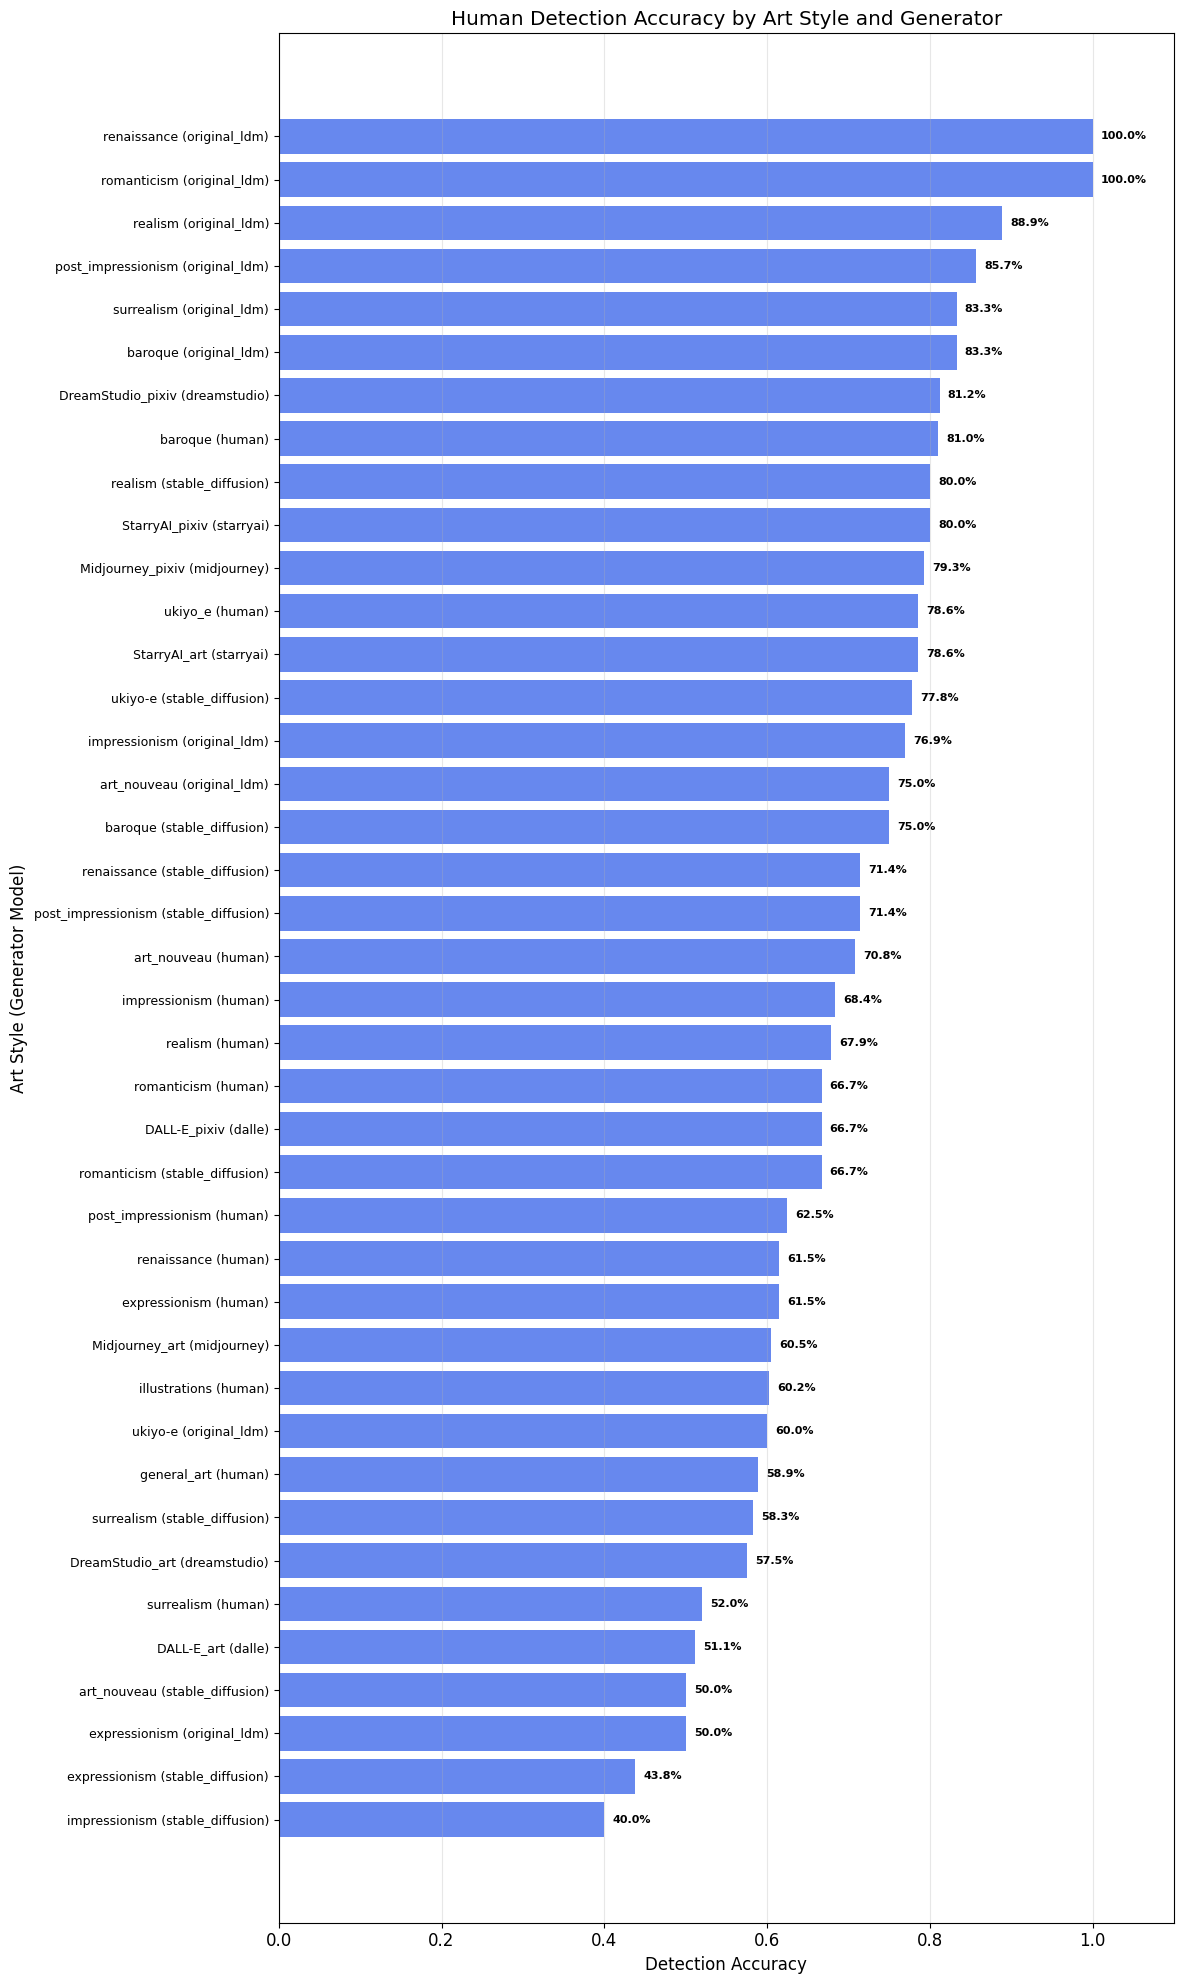

In [ ]:
# Human Detection Accuracy by Art Style and Generator 
# This cell is generated by Claude AI assistant 
if 'art_style' in votes_finished.columns:
    # Calculate accuracy by art style and generator model
    style_gen_accuracy = votes_finished.groupby(['art_style', 'generator_model']).agg({
        'correct': ['count', 'mean'],
        'confidence': 'mean' if 'confidence' in votes_finished.columns else 'count'
    }).round(3)
    style_gen_accuracy.columns = ['Total_Votes', 'Accuracy', 'Avg_Confidence']
    style_gen_accuracy = style_gen_accuracy.reset_index()
    
    # Create combined label for y-axis
    style_gen_accuracy['combined_label'] = style_gen_accuracy['art_style'] + ' (' + style_gen_accuracy['generator_model'] + ')'
    
    # Sort by accuracy (ascending for horizontal bar chart)
    style_gen_accuracy = style_gen_accuracy.sort_values('Accuracy', ascending=True)
    
    plt.figure(figsize=(12, 20))
    bars = plt.barh(range(len(style_gen_accuracy)), style_gen_accuracy['Accuracy'])
    plt.title('Human Detection Accuracy by Art Style and Generator')
    plt.ylabel('Art Style (Generator Model)')
    plt.xlabel('Detection Accuracy')
    plt.yticks(range(len(style_gen_accuracy)), style_gen_accuracy['combined_label'], fontsize=9)
    
    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{style_gen_accuracy.iloc[i]["Accuracy"]:.1%}', 
                 ha='left', va='center', fontsize=8, fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.xlim(0, 1.1)  # Set x-axis limit to accommodate labels
    plt.tight_layout()
    plt.show()
else:
    print("Style data not available")

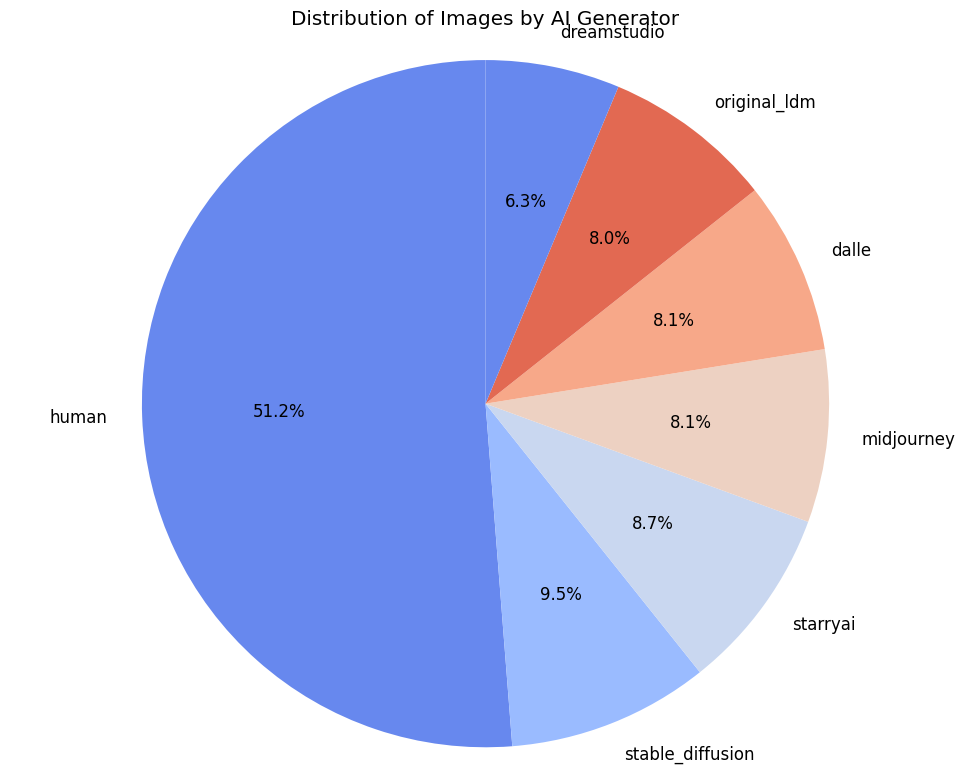

In [ ]:
# Generator Distribution 
if 'generator_model' in votes_finished.columns:
    plt.figure(figsize=(10, 8))
    gen_dist = votes_finished['generator_model'].value_counts()
    plt.pie(gen_dist.values, labels=gen_dist.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Images by AI Generator')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Generator data not available")

#### Results vs Order Shown 

In [ ]:
# Order effects and overall accuracy metrics
print("RESULTS VS ORDER SHOWN")

if 'order_shown' in votes_finished.columns:
    print("Accuracy by position in test:")
    for order in sorted(votes_finished['order_shown'].unique()):
        subset = votes_finished[votes_finished['order_shown'] == order]
        acc = subset['correct'].mean()
        count = len(subset)
        print(f"  Position {order}: {acc:.1%} ({count} responses)")



RESULTS VS ORDER SHOWN
Accuracy by position in test:
  Position 1: 66.7% (81 responses)
  Position 2: 69.3% (88 responses)
  Position 3: 58.5% (94 responses)
  Position 4: 58.8% (85 responses)
  Position 5: 58.1% (86 responses)
  Position 6: 67.8% (87 responses)
  Position 7: 64.4% (90 responses)
  Position 8: 73.6% (91 responses)
  Position 9: 64.0% (86 responses)
  Position 10: 78.3% (83 responses)
  Position 11: 69.2% (13 responses)
  Position 12: 100.0% (2 responses)


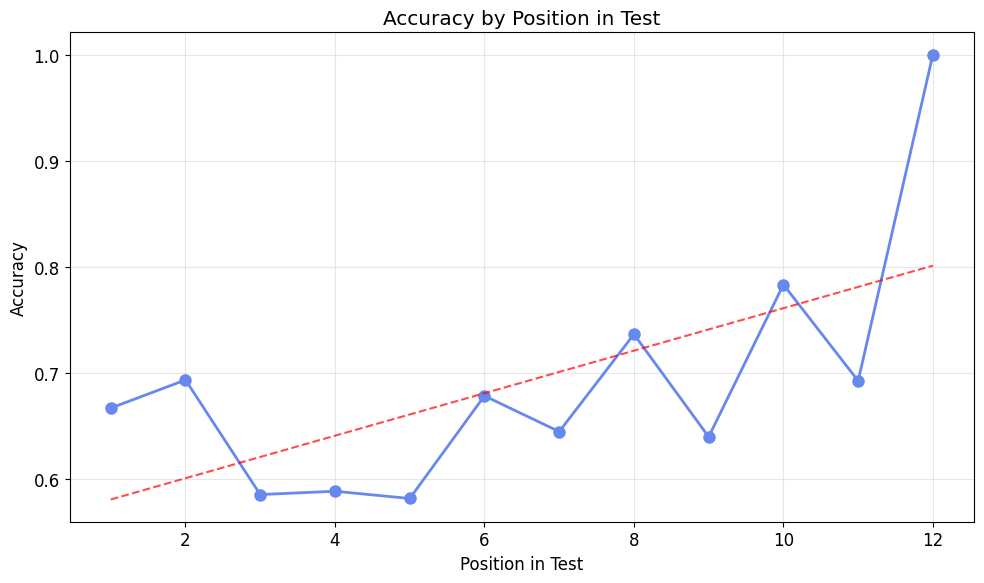

In [ ]:
# Accuracy by Position in Test
if 'order_shown' in votes_finished.columns:
    plt.figure(figsize=(10, 6))
    order_means = votes_finished.groupby('order_shown')['correct'].mean()
    plt.plot(order_means.index, order_means.values, marker='o', linewidth=2, markersize=8)
    plt.title('Accuracy by Position in Test')
    plt.xlabel('Position in Test')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(order_means.index, order_means.values, 1)
    p = np.poly1d(z)
    plt.plot(order_means.index, p(order_means.index), "r--", alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Order data not available")

### 3.2 Qualitative Analysis

#### Visual Cues, Concerns, and Emotions

In [ ]:
# Qualitative Analysis - Visual Cues and Participant Responses


if 'visual_cues' in participants_clean.columns:
    # Extract and count visual cues (comma-separated values)
    all_cues = []
    for cues in participants_clean['visual_cues'].dropna():
        if cues and cues != '':
            cue_list = [cue.strip() for cue in str(cues).split(',')]
            all_cues.extend(cue_list)
    
    cue_counts = pd.Series(all_cues).value_counts()
    print("Most commonly reported visual cues:")
    for cue, count in cue_counts.head(10).items():
        print(f"  '{cue}': {count} mentions")
else:
    print("Visual cues data not available")



Most commonly reported visual cues:
  'Anatomy issues (e.g.': 48 mentions
  'hands': 48 mentions
  'faces)': 48 mentions
  'Overall 'uncanny' feeling': 35 mentions
  'Level of detail/smoothness': 26 mentions
  'Unusual lighting or shadows': 25 mentions
  'Text/writing artifacts': 21 mentions
  'Texture/brushstrokes': 19 mentions
  'Content/Subject matter': 12 mentions
  'Unnatural colours / saturation': 12 mentions


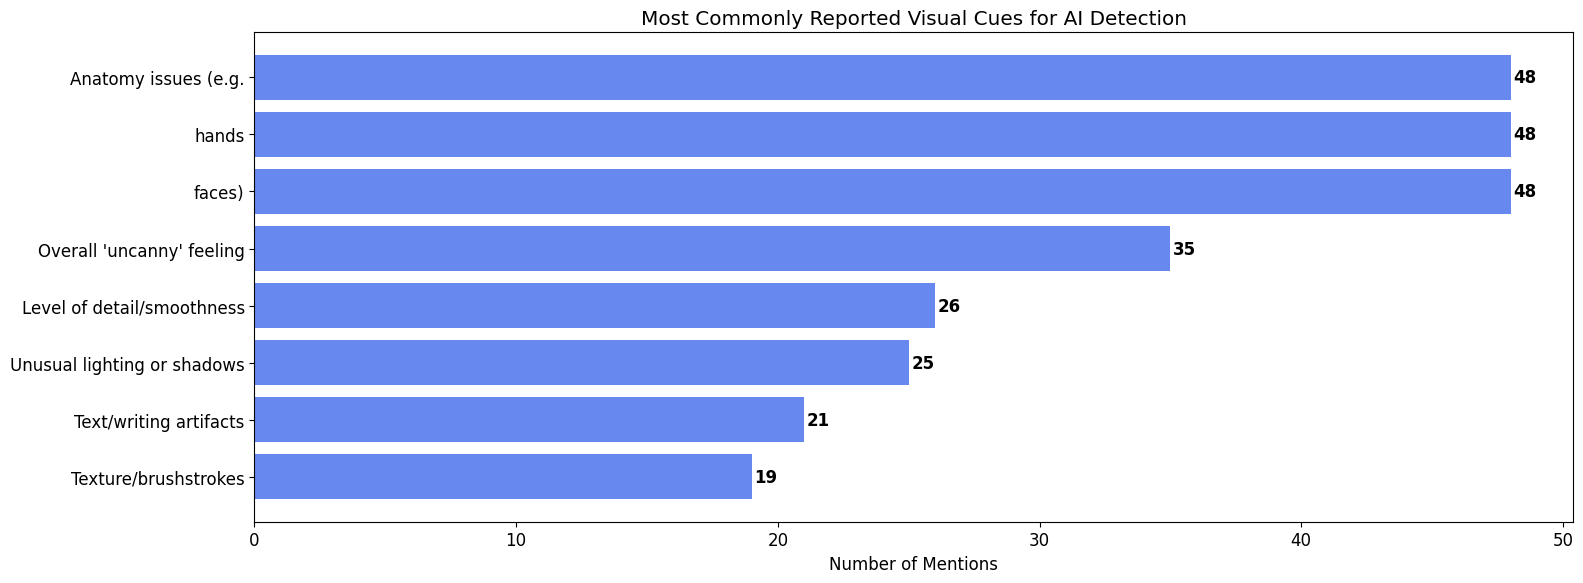

In [ ]:
# Visual Cues for AI Detection
if 'visual_cues' in participants_clean.columns:
    plt.figure(figsize=(16, 6))
    top_cues = cue_counts.head(8)
    plt.barh(range(len(top_cues)), top_cues.values)
    plt.yticks(range(len(top_cues)), top_cues.index)
    plt.xlabel('Number of Mentions')
    plt.title('Most Commonly Reported Visual Cues for AI Detection')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, (cue, count) in enumerate(top_cues.items()):
        plt.text(count + 0.1, i, str(count), va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Visual cues data not available")

In [ ]:
print("\n=== HARDEST STYLES (PARTICIPANT REPORTED) ===")
if 'hardest_styles' in participants_clean.columns:
    # Extract hardest styles
    all_hard_styles = []
    for styles in participants_clean['hardest_styles'].dropna():
        if styles and styles != '':
            style_list = [style.strip() for style in str(styles).split(',')]
            all_hard_styles.extend(style_list)
    
    hard_style_counts = pd.Series(all_hard_styles).value_counts()
    print("Styles participants found hardest to detect:")
    for style, count in hard_style_counts.head(10).items():
        print(f"  '{style}': {count} mentions")
else:
    print("Hardest styles data not available")


=== HARDEST STYLES (PARTICIPANT REPORTED) ===
Styles participants found hardest to detect:
  'Abstract art': 41 mentions
  'Paintings': 37 mentions
  'Anime/illustrations': 26 mentions
  'Sketches': 16 mentions


In [ ]:
print("\n=== CONCERNS ABOUT AI ART ===")
if 'concerns' in participants_clean.columns:
    # Extract concerns (comma-separated)
    all_concerns = []
    for concerns in participants_clean['concerns'].dropna():
        if concerns and concerns != '':
            concern_list = [concern.strip() for concern in str(concerns).split(',')]
            all_concerns.extend(concern_list)
    
    concern_counts = pd.Series(all_concerns).value_counts()
    print("Most common concerns about AI art:")
    for concern, count in concern_counts.head(10).items():
        print(f"  '{concern}': {count} mentions")
else:
    print("Concerns data not available")


=== CONCERNS ABOUT AI ART ===
Most common concerns about AI art:
  'Difficulty proving originality': 46 mentions
  'Devaluation of human creativity': 45 mentions
  'AI training on work without permission': 42 mentions
  'Copyright concerns': 42 mentions
  'AI content flooding platforms': 40 mentions
  'Other': 3 mentions


In [ ]:
# Importance of Labeling AI-Generated Art


if 'labeling_importance' in participants_clean.columns:
    labeling_importance = participants_clean['labeling_importance'].value_counts()
    print("How important is labeling AI art:")
    for importance, count in labeling_importance.items():
        if pd.notna(importance):
            print(f"  {importance}: {count} participants")
else:
    print("Labeling importance data not available")

How important is labeling AI art:
  Extremely important: 42 participants
  Very important: 24 participants
  Somewhat important: 14 participants
  Not important at all: 2 participants
  Not very important: 2 participants


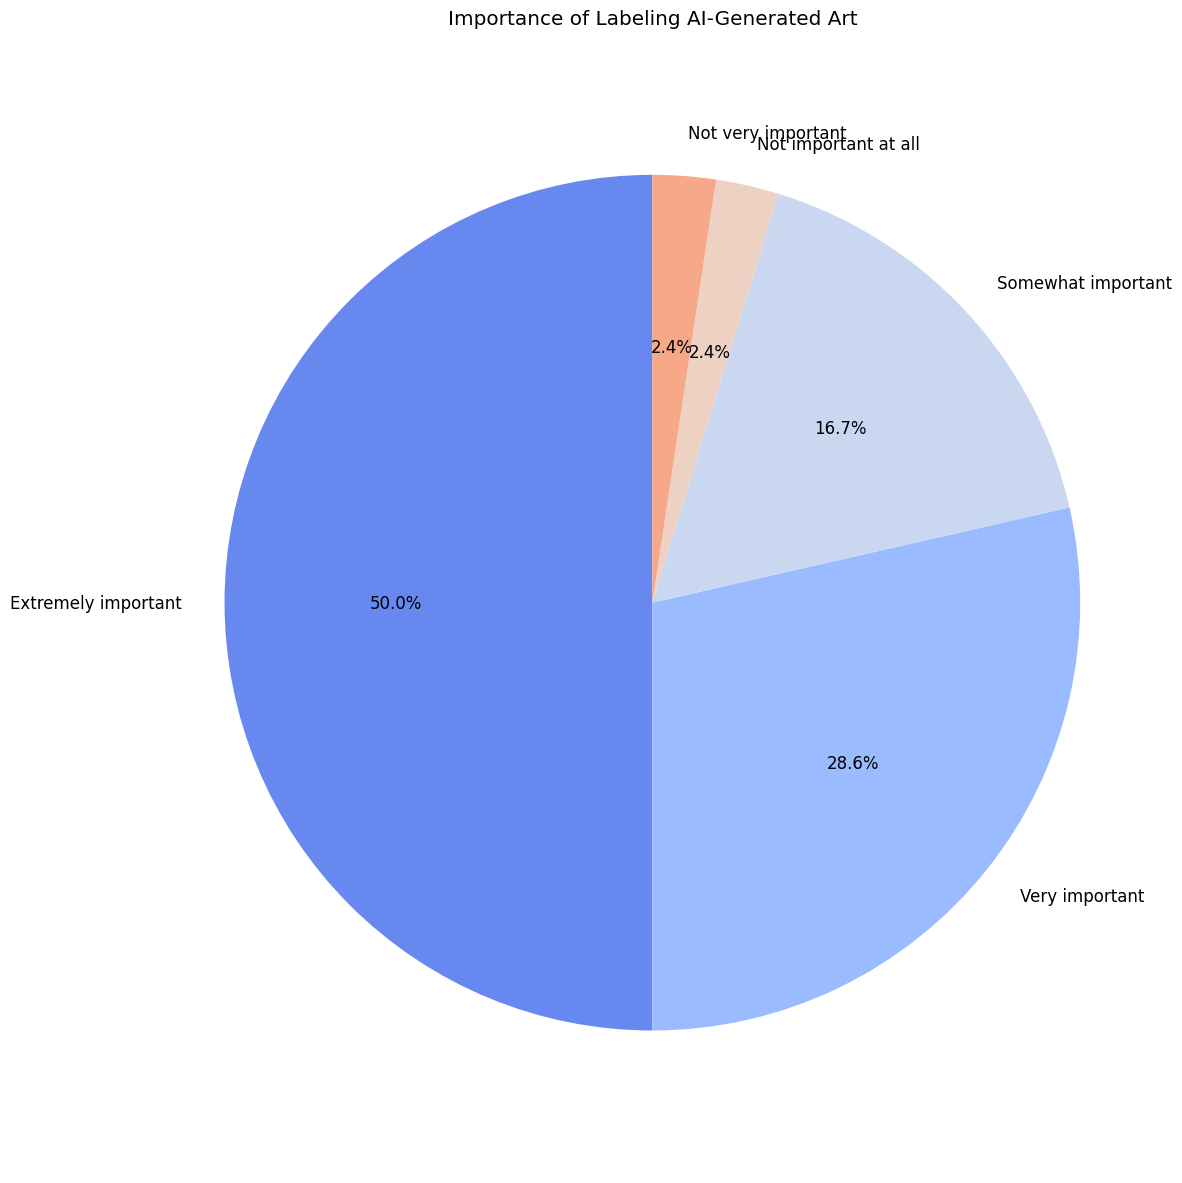

In [ ]:
# Importance of Labeling AI-Generated Art
if 'labeling_importance' in participants_clean.columns:
    plt.figure(figsize=(12, 12))
    plt.pie(labeling_importance.values, labels=labeling_importance.index, 
           autopct='%1.1f%%', startangle=90)
    plt.title('Importance of Labeling AI-Generated Art')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Labeling importance data not available")

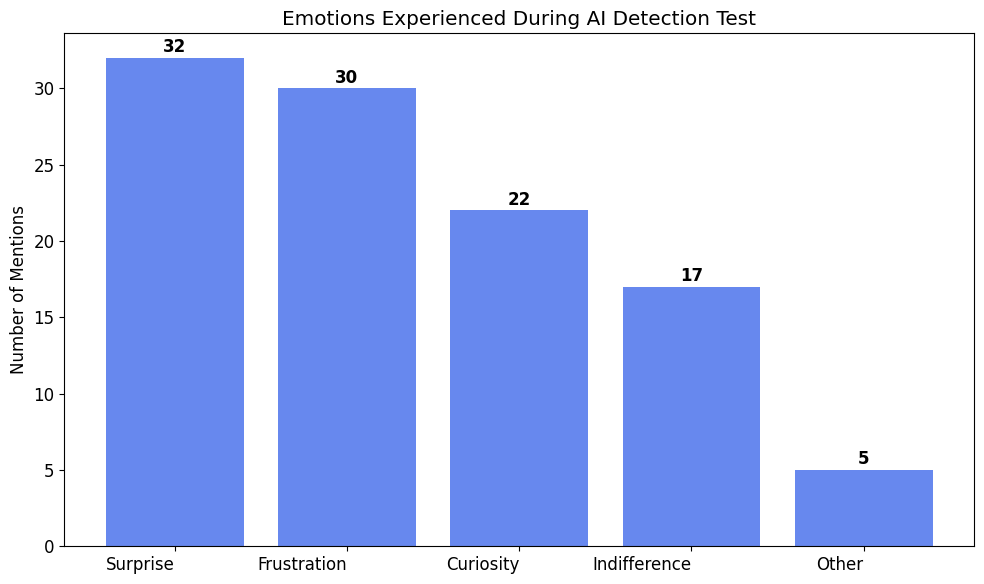

In [ ]:
# Emotions Experienced During AI Detection Test
if 'emotions' in participants_clean.columns:
    plt.figure(figsize=(10, 6))
    top_emotions = emotion_counts.head(8)
    plt.bar(range(len(top_emotions)), top_emotions.values)
    plt.xticks(range(len(top_emotions)), top_emotions.index, ha='right')
    plt.ylabel('Number of Mentions')
    plt.title('Emotions Experienced During AI Detection Test')
    
    # Add value labels
    for i, (emotion, count) in enumerate(top_emotions.items()):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Emotions data not available")

------------------------------



## 4. AI Detector Results (NOT VALID!! DUE TO DEPLOYMENT ERROR)

In [ ]:
# AI Detector Performance Analysis
print("AI DETECTOR RESULTS")

if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    detector_data = votes_finished[votes_finished['detector_pred'].notna()].copy()
    detector_data['detector_correct'] = detector_data['detector_pred'] == detector_data['true_label']
    
    print(f"AI detector predictions available for {len(detector_data)} votes")
    
    # Overall accuracy during game
    overall_detector_accuracy = detector_data['detector_correct'].mean()
    print(f"\n Overall AI Detector Accuracy: {overall_detector_accuracy:.1%}")
    
    # Average confidence 
    if 'detector_confidence' in detector_data.columns:
        avg_confidence = detector_data['detector_confidence'].mean()
        confidence_std = detector_data['detector_confidence'].std()
        print(f" Average AI Detector Confidence: {avg_confidence:.1%} (±{confidence_std:.1%})")
    
    # Human-made vs AI-generated predictions
    print(f"\n=== PREDICTIONS BY IMAGE TYPE ===")
    image_type_results = detector_data.groupby('true_label').agg({
        'detector_correct': ['count', 'mean'],
        'detector_confidence': 'mean' if 'detector_confidence' in detector_data.columns else 'count'
    }).round(3)
    
    print("Human-made images predictions:")
    human_acc = image_type_results.loc['human', ('detector_correct', 'mean')] if 'human' in image_type_results.index else 0
    human_count = image_type_results.loc['human', ('detector_correct', 'count')] if 'human' in image_type_results.index else 0
    print(f"  Accuracy: {human_acc:.1%} ({human_count} images)")
    
    print("AI-generated images predictions:")
    ai_acc = image_type_results.loc['ai', ('detector_correct', 'mean')] if 'ai' in image_type_results.index else 0
    ai_count = image_type_results.loc['ai', ('detector_correct', 'count')] if 'ai' in image_type_results.index else 0
    print(f"  Accuracy: {ai_acc:.1%} ({ai_count} images)")
    
else:
    print(" No AI detector prediction data available")

AI DETECTOR RESULTS
AI detector predictions available for 886 votes

 Overall AI Detector Accuracy: 52.0%
 Average AI Detector Confidence: 74.2% (±14.4%)

=== PREDICTIONS BY IMAGE TYPE ===
Human-made images predictions:
  Accuracy: 49.1% (454 images)
AI-generated images predictions:
  Accuracy: 55.1% (432 images)


In [ ]:
# AI Detector Accuracy by Style
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    print("=== ACCURACY PER STYLE ===")
    if 'art_style' in detector_data.columns:
        style_detector_acc = detector_data.groupby('art_style').agg({
            'detector_correct': ['count', 'mean'],
            'detector_confidence': 'mean' if 'detector_confidence' in detector_data.columns else 'count'
        }).round(3)
        style_detector_acc.columns = ['Count', 'AI_Accuracy', 'AI_Confidence']
        style_detector_acc = style_detector_acc.reset_index().sort_values('AI_Accuracy', ascending=False)
        
        for _, row in style_detector_acc.head(10).iterrows():
            conf_str = f", conf: {row['AI_Confidence']:.1%}" if 'detector_confidence' in detector_data.columns else ""
            print(f"  {row['art_style']}: {row['AI_Accuracy']:.1%} ({row['Count']} votes{conf_str})")
    else:
        print("Art style data not available")
else:
    print("No AI detector data available")

=== ACCURACY PER STYLE ===
  post_impressionism: 73.7% (38 votes, conf: 72.6%)
  Midjourney_pixiv: 65.5% (29 votes, conf: 74.8%)
  StarryAI_art: 64.3% (42 votes, conf: 73.7%)
  ukiyo-e: 64.3% (14 votes, conf: 70.3%)
  Midjourney_art: 62.8% (43 votes, conf: 77.1%)
  baroque: 60.0% (35 votes, conf: 74.4%)
  StarryAI_pixiv: 57.1% (35 votes, conf: 76.3%)
  romanticism: 56.7% (30 votes, conf: 74.1%)
  DreamStudio_pixiv: 56.2% (16 votes, conf: 71.5%)
  DALL-E_pixiv: 55.6% (27 votes, conf: 73.6%)


In [ ]:
# AI Detector Accuracy by Generator
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    print("ACCURACY PER GENERATOR")
    if 'generator_model' in detector_data.columns:
        gen_detector_acc = detector_data.groupby('generator_model').agg({
            'detector_correct': ['count', 'mean'],
            'detector_confidence': 'mean' if 'detector_confidence' in detector_data.columns else 'count'
        }).round(3)
        gen_detector_acc.columns = ['Count', 'AI_Accuracy', 'AI_Confidence']
        gen_detector_acc = gen_detector_acc.reset_index().sort_values('AI_Accuracy', ascending=False)
        
        for _, row in gen_detector_acc.iterrows():
            conf_str = f", conf: {row['AI_Confidence']:.1%}" if 'detector_confidence' in detector_data.columns else ""
            print(f"  {row['generator_model']}: {row['AI_Accuracy']:.1%} ({row['Count']} votes{conf_str})")
    else:
        print("Generator data not available")
else:
    print("No AI detector data available")

ACCURACY PER GENERATOR
  midjourney: 63.9% (72 votes, conf: 76.2%)
  starryai: 61.0% (77 votes, conf: 74.9%)
  original_ldm: 57.7% (71 votes, conf: 73.6%)
  stable_diffusion: 52.4% (84 votes, conf: 74.0%)
  dreamstudio: 50.0% (56 votes, conf: 73.1%)
  human: 49.1% (454 votes, conf: 74.0%)
  dalle: 44.4% (72 votes, conf: 73.9%)


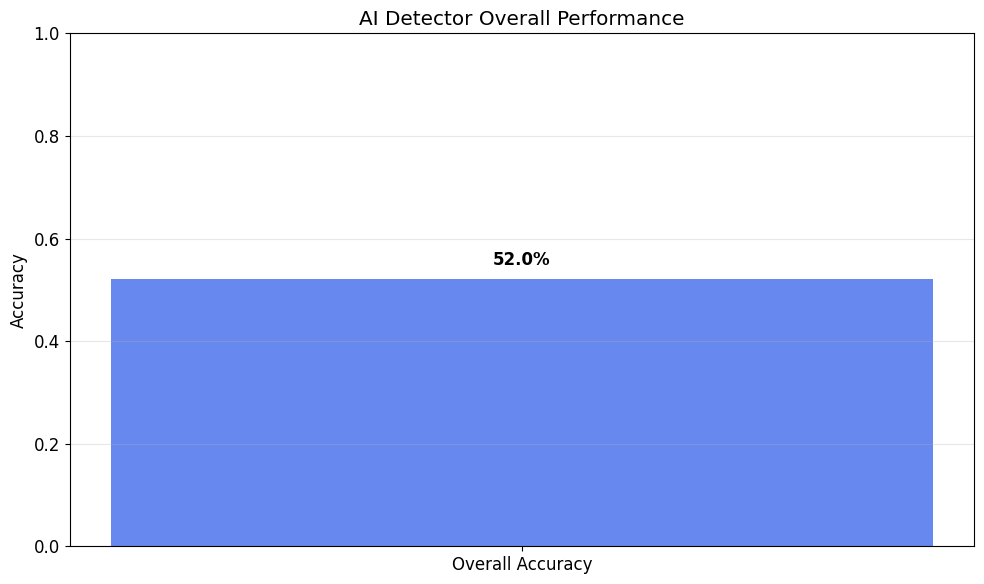

In [ ]:
# AI Detector Overall Performance
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    plt.figure(figsize=(10, 6))
    categories = ['Overall Accuracy']
    values = [overall_detector_accuracy]
    
    bars = plt.bar(categories, values)
    plt.title('AI Detector Overall Performance')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.1%}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No AI detector data available")

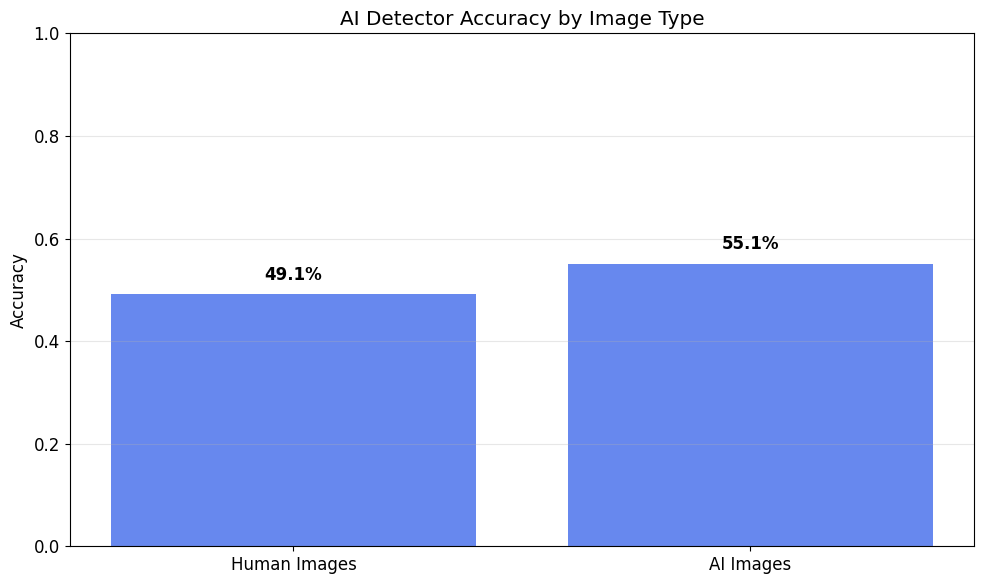

In [ ]:
# AI Detector Performance by Image Type
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    plt.figure(figsize=(10, 6))
    image_types = ['Human Images', 'AI Images']
    accuracies = [human_acc, ai_acc]
    bars = plt.bar(image_types, accuracies)
    plt.title('AI Detector Accuracy by Image Type')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{accuracies[i]:.1%}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No AI detector data available")

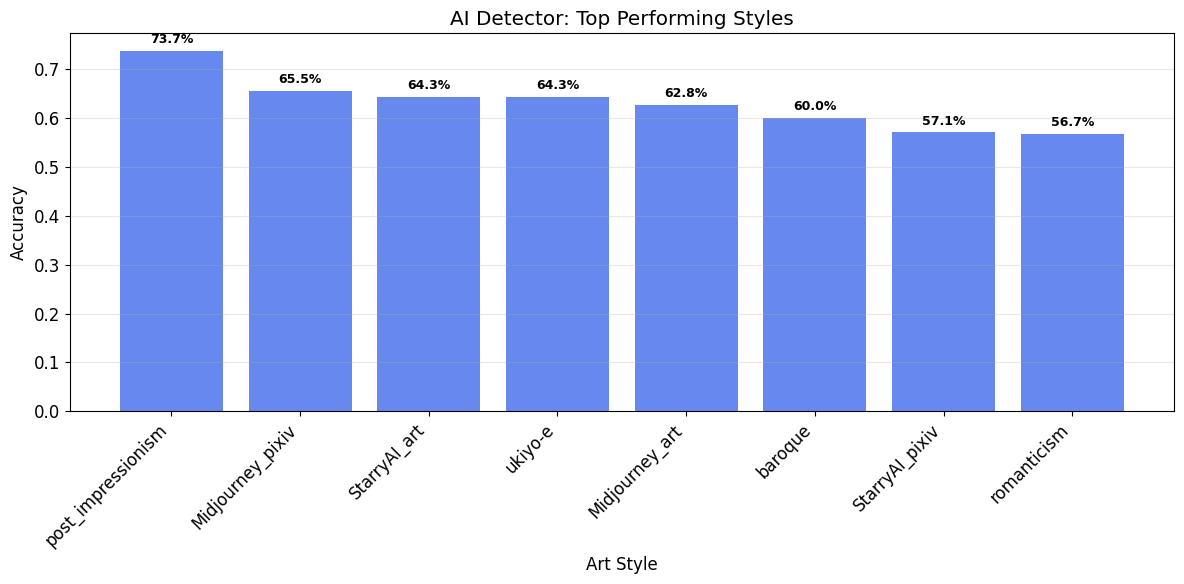

In [ ]:
# AI Detector Top Performing Styles
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    detector_data = votes_finished[votes_finished['detector_pred'].notna()].copy()
    detector_data['detector_correct'] = detector_data['detector_pred'] == detector_data['true_label']
    
    if 'art_style' in detector_data.columns:
        # Calculate AI detector accuracy by style
        style_detector_acc = detector_data.groupby('art_style').agg({
            'detector_correct': ['count', 'mean'],
            'detector_confidence': 'mean' if 'detector_confidence' in detector_data.columns else 'count'
        }).round(3)
        style_detector_acc.columns = ['Count', 'AI_Accuracy', 'AI_Confidence']
        style_detector_acc = style_detector_acc.reset_index().sort_values('AI_Accuracy', ascending=False)
        
        plt.figure(figsize=(12, 6))
        top_styles = style_detector_acc.head(8)
        bars = plt.bar(range(len(top_styles)), top_styles['AI_Accuracy'])
        plt.title('AI Detector: Top Performing Styles')
        plt.xlabel('Art Style')
        plt.ylabel('Accuracy')
        plt.xticks(range(len(top_styles)), top_styles['art_style'], rotation=45, ha='right')
        
        # Add value labels with proper percentage formatting
        for i, bar in enumerate(bars):
            accuracy_val = top_styles.iloc[i]['AI_Accuracy']
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{accuracy_val:.1%}', 
                     ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("Art style data not available")
else:
    print("No AI detector data available")

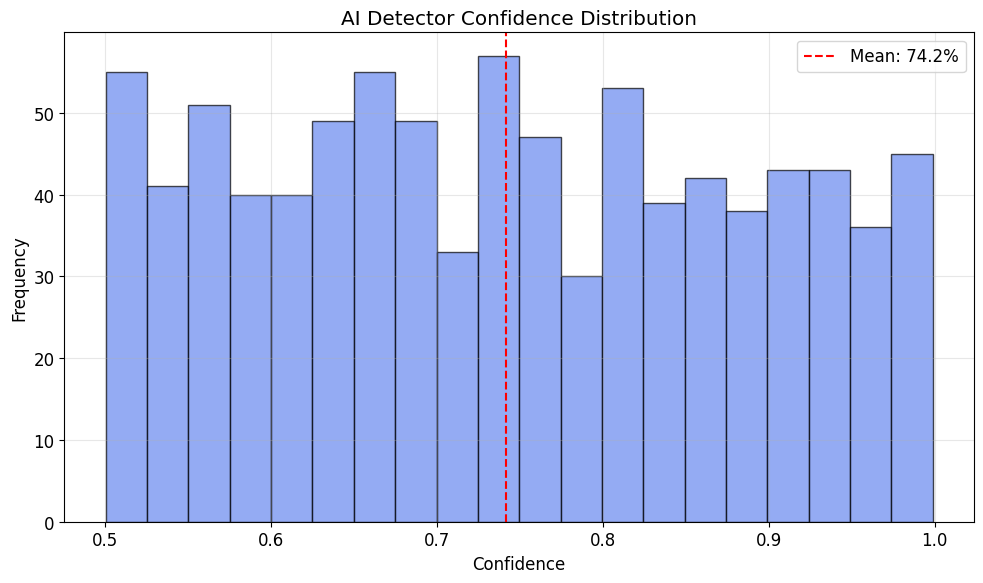

In [ ]:
# AI Detector Confidence Distribution
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    if 'detector_confidence' in detector_data.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(detector_data['detector_confidence'], bins=20, alpha=0.7, edgecolor='black')
        plt.axvline(avg_confidence, color='red', linestyle='--', 
                   label=f'Mean: {avg_confidence:.1%}')
        plt.title('AI Detector Confidence Distribution')
        plt.xlabel('Confidence')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("AI detector confidence data not available")
else:
    print("No AI detector data available")

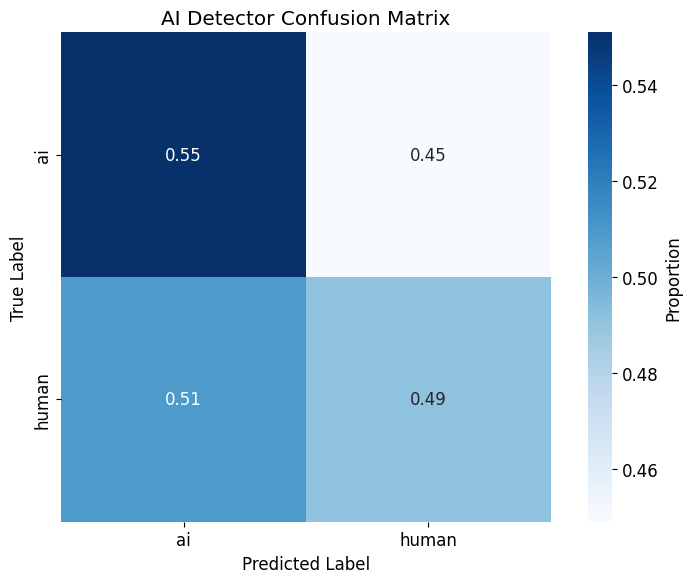

In [ ]:
# AI Detector Confusion Matrix
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    plt.figure(figsize=(8, 6))
    confusion_data = pd.crosstab(detector_data['true_label'], detector_data['detector_pred'], 
                                normalize='index')
    
    sns.heatmap(confusion_data, annot=True, fmt='.2f', cmap='Blues', 
               square=True, cbar_kws={'label': 'Proportion'})
    plt.title('AI Detector Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
else:
    print("No AI detector data available")

---------------------------------------------


## 5. Human Detectors vs AI Detector Comparison (NOT VALID!! DUE TO DEPLOYMENT ERROR)

In [ ]:
# Direct Comparison: Human vs AI Detection Performance
print("HUMAN vs AI DETECTOR COMPARISON")

if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    
    # Overall performance comparison
    human_overall_acc = votes_finished['correct'].mean()
    ai_overall_acc = detector_data['detector_correct'].mean()
    performance_gap = human_overall_acc - ai_overall_acc
    
    print(f"\n OVERALL PERFORMANCE")
    print(f"Human accuracy:     {human_overall_acc:.1%}")
    print(f"AI detector accuracy: {ai_overall_acc:.1%}")
    print(f"Performance gap:    {performance_gap:+.1%} {'(Human advantage)' if performance_gap > 0 else '(AI advantage)'}")
    
    # Performance by image type
    print(f"\n PERFORMANCE BY IMAGE TYPE")
    human_by_type = votes_finished.groupby('true_label')['correct'].mean()
    ai_by_type = detector_data.groupby('true_label')['detector_correct'].mean()
    
    for img_type in ['ai', 'human']:
        if img_type in human_by_type.index and img_type in ai_by_type.index:
            h_acc = human_by_type[img_type]
            a_acc = ai_by_type[img_type]
            gap = h_acc - a_acc
            print(f"{img_type.upper()} images:")
            print(f"  Human: {h_acc:.1%}, AI: {a_acc:.1%}, Gap: {gap:+.1%}")
    
else:
    print("Cannot perform comparison - AI detector data not available")

HUMAN vs AI DETECTOR COMPARISON

 OVERALL PERFORMANCE
Human accuracy:     66.0%
AI detector accuracy: 52.0%
Performance gap:    +14.0% (Human advantage)

 PERFORMANCE BY IMAGE TYPE
AI images:
  Human: 68.8%, AI: 55.1%, Gap: +13.7%
HUMAN images:
  Human: 63.4%, AI: 49.1%, Gap: +14.3%


In [ ]:
# Performance by Generator Comparison
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    print(" PERFORMANCE BY GENERATOR")
    if 'generator_model' in votes_finished.columns:
        human_by_gen = votes_finished.groupby('generator_model')['correct'].mean()
        ai_by_gen = detector_data.groupby('generator_model')['detector_correct'].mean()
        
        comparison_gen = pd.DataFrame({
            'Human_Acc': human_by_gen,
            'AI_Acc': ai_by_gen
        }).fillna(0)
        comparison_gen['Gap'] = comparison_gen['Human_Acc'] - comparison_gen['AI_Acc']
        comparison_gen = comparison_gen.sort_values('Gap', ascending=False)
        
        for gen, row in comparison_gen.iterrows():
            if row['Human_Acc'] > 0 or row['AI_Acc'] > 0:  # Only show if we have data
                print(f"  {gen}: Human {row['Human_Acc']:.1%}, AI {row['AI_Acc']:.1%}, Gap {row['Gap']:+.1%}")
    else:
        print("Generator data not available")
else:
    print("No AI detector data available")

 PERFORMANCE BY GENERATOR
  original_ldm: Human 81.7%, AI 57.7%, Gap +23.9%
  starryai: Human 79.2%, AI 61.0%, Gap +18.2%
  human: Human 63.4%, AI 49.1%, Gap +14.3%
  dreamstudio: Human 64.3%, AI 50.0%, Gap +14.3%
  dalle: Human 56.9%, AI 44.4%, Gap +12.5%
  stable_diffusion: Human 61.9%, AI 52.4%, Gap +9.5%
  midjourney: Human 68.1%, AI 63.9%, Gap +4.2%


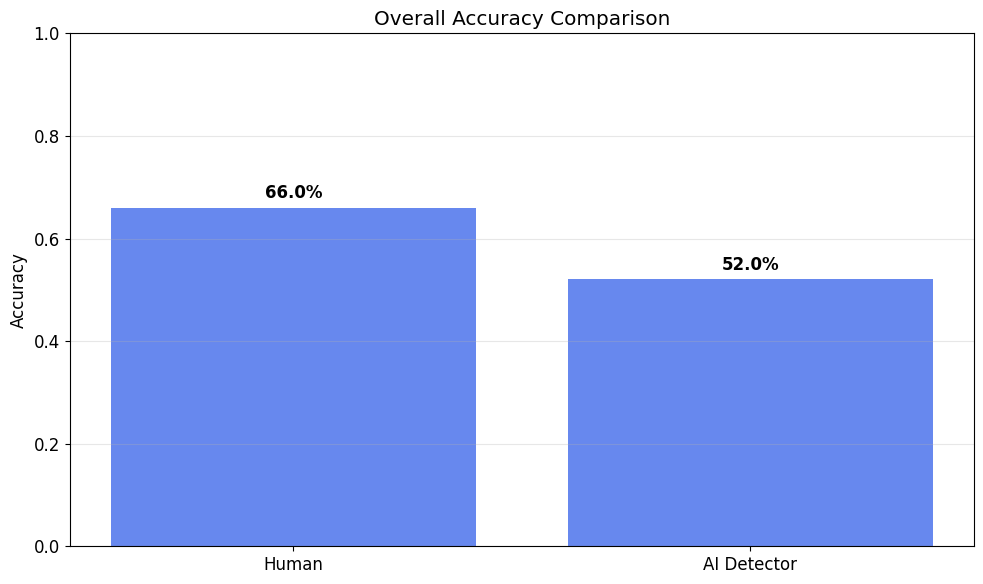

In [ ]:
# Overall Accuracy Comparison Chart
if 'detector_pred' in votes_finished.columns and votes_finished['detector_pred'].notna().any():
    plt.figure(figsize=(10, 6))
    categories = ['Human', 'AI Detector']
    accuracies = [human_overall_acc, ai_overall_acc]
    bars = plt.bar(categories, accuracies)
    plt.title('Overall Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{accuracies[i]:.1%}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No AI detector data available")

------------------------------

# Export Cleaned Data

In [ ]:
# Export Cleaned Data

# Define output directory
import os
output_dir = "../data/cleaned_data/"
os.makedirs(output_dir, exist_ok=True)

# 1. Export cleaned votes data
votes_output_path = f"{output_dir}votes_cleaned.csv"
votes_finished.to_csv(votes_output_path, index=False)
print(f" Cleaned votes data exported: {votes_output_path}")
print(f"   - {len(votes_finished)} rows, {len(votes_finished.columns)} columns")

# 2. Export cleaned participants data
participants_output_path = f"{output_dir}participants_cleaned.csv"
participants_clean.to_csv(participants_output_path, index=False)
print(f" Cleaned participants data exported: {participants_output_path}")
print(f"   - {len(participants_clean)} rows, {len(participants_clean.columns)} columns")



print(f"\n All cleaned files saved to: {output_dir}")

 Cleaned votes data exported: ../data/cleaned_data/votes_cleaned.csv
   - 886 rows, 16 columns
 Cleaned participants data exported: ../data/cleaned_data/participants_cleaned.csv
   - 84 rows, 23 columns

 All cleaned files saved to: ../data/cleaned_data/
